This notebook serves as
* initial draft for topics review using different prompt instructions, title approaches
* prototype of topic summarization validation through idea of matched human written sections in review paper with generated summary from PubMed topic clusters. Comparision is done using cosine distances for text embeddings pairs

P.S: Notebook could be launched sequentially

In [ ]:
import os
VERTEX_CLIENT_PROJECT = os.getenv('VERTEX_CLIENT_PROJECT', 'default_project')

In [3]:

from bokeh.plotting import show, output_notebook

output_notebook()

%matplotlib inline
%config InlineBackend.figure_format='retina'

Loading BokehJS ...

In [4]:
import os.path

import pandas as pd
import requests
import json
import re
from urllib.parse import urlencode

from fontTools.ttLib.tables.ttProgram import instructions

In [38]:
import os
import numpy as np

In [6]:
import gzip

from pysrc.papers.data import AnalysisData

In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Test Data: Export Review Paper to Json

In [154]:
def make_request_and_show_link_to_result(pmid, pmid_n_topics):
    url = "https://pubtrends.info/search_paper"
    data = {
        "key": "id",
        "value": "36599349",
        "source": "Pubmed",
        "limit": "1000",
        "topics": "12",
        "expand": "1"
    }
    response = requests.post(url, data=data)

    # Print or parse the response
    print("Request response:", response.status_code)
    assert response.status_code == 200

    chunks = response.text.split("\n")

    for i in range(len(chunks)):
        l = chunks[i]
        if "// Join arg-value pairs for URL" in l:
            # Step 1: Clean data:
            url_args_str = chunks[i+1].strip().replace("var args = {", "{").replace("};", "}")
            url_args_str_json = re.sub(r"'", '"', url_args_str)

            # Step 2: Parse into a dictionary
            url_params = json.loads(url_args_str_json)

            # Step 3: Create query string
            query_string = urlencode(url_params)

            # Step 4: Final URL
            final_url = f"https://pubtrends.info/paper?{query_string}"

            return final_url

    print("ERROR: Something went wrong.")
    return None

In [155]:
pmid, pmid_n_topics = 36599349, 12
make_request_and_show_link_to_result(pmid, pmid_n_topics)

Request response: 200


'https://pubtrends.info/paper?query=Papers%2520id%253D36599349&source=Pubmed&jobid=ed1eafce-5d1f-4724-8e42-7a793b71557a&sort=&key=id&value=36599349&limit=1000&topics=12&noreviews=off'

In [26]:
chunks = response.text.split("\n")
final_url
for i in range(len(chunks)):
    l = chunks[i]
    if "// Join arg-value pairs for URL" in l:
        # Step 1: Clean data:
        url_args_str = chunks[i+1].strip().replace("var args = {", "{").replace("};", "}")
        url_args_str_json = re.sub(r"'", '"', url_args_str)

        # Step 2: Parse into a dictionary
        url_params = json.loads(url_args_str_json)

        # Step 3: Create query string
        query_string = urlencode(url_params)

        # Step 4: Final URL
        final_url = f"https://pubtrends.info/paper?{query_string}"

        print(final_url)

        break

https://pubtrends.info/paper?query=Papers%2520id%253D36599349&source=Pubmed&jobid=be9d820d-2d80-4171-9bbe-e891c7912606&sort=&key=id&value=36599349&limit=1000&topics=12&noreviews=off


# Embeddings Playground (tutorial)

See https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings

In [60]:
from google import genai
from google.genai.types import EmbedContentConfig

client = genai.Client(
  vertexai=True,
  project=VERTEX_CLIENT_PROJECT,
  location="us-central1",
)
response = client.models.embed_content(
    model="text-embedding-005", #text-multilingual-embedding-002
    contents=[
        "How do I get a driver's license/learner's permit?",
        "How do I renew my driver's license?",
        "How do I change my address on my driver's license?",
    ],
    config=EmbedContentConfig(
        task_type="RETRIEVAL_DOCUMENT",  # Optional
        output_dimensionality=768,  # Optional
        title="Driver's License",  # Optional
    ),
)

# print(response)
print("----")
print("# vectors", len(response.embeddings))
# print(response.statistics)
print(response.metadata)


# Example response:
# embeddings=[ContentEmbedding(values=[-0.06302902102470398, 0.00928034819662571, 0.014716853387653828, -0.028747491538524628, ... ],
# statistics=ContentEmbeddingStatistics(truncated=False, token_count=13.0))]
# metadata=EmbedContentMetadata(billable_character_count=112)

----
# vectors 3
billable_character_count=157


In [55]:
# type(response.metadata)
len(response.embeddings)

3

# Embeddings Playground

In [134]:
hallmarks_of_aging_topics = {}

## Test data

In [135]:
hallmarks_of_aging_topics['Genomic instability'] = """
Genomic instability
Genome integrity and stability are pervasively threatened by exogenous chemical, physical, and biological agents, as well as by endogenous challenges such as DNA replication errors, chromosome segregation defects, oxidative processes, and spontaneous hydrolytic reactions. The wide range of genetic lesions caused by these extrinsic or intrinsic sources of damage include point mutations, deletions, translocations, telomere shortening, single- and double-strand breaks, chromosomal rearrangements, defects in nuclear architecture, and gene disruption caused by the integration of viruses or transposons. All these molecular alterations and the resulting genomic mosaicism may contribute to both normal and pathological aging.3 Accordingly, organisms have evolved a complex array of DNA repair and maintenance mechanisms to deal with the damage inflicted to nuclear and mitochondrial DNA (mtDNA) and to ensure the appropriate chromosomal architecture and stability. These DNA repair networks lose efficiency with age, which accentuates the accumulation of genomic damage and the ectopic accumulation of DNA in the cytosol4 (Figure 2A).
Nuclear DNA
Cells from aged humans and model organisms accumulate somatic mutations at nuclear DNA.5 Other forms of damage, such as chromosomal aneuploidy and copy-number variations, are also associated with aging. All these DNA alterations may affect essential genes and transcriptional pathways, resulting in dysfunctional cells that may finally compromise tissue and organismal homeostasis. This is especially relevant when DNA damage impacts on stem cells, hampering their role in tissue renewal or leading to their exhaustion, which in turn promotes aging and increases susceptibility to age-related pathologies.6,7 The mutational burden in histologically normal human tissues is remarkable. For example, normal esophageal epithelium cells from young individuals already display hundreds of mutations and may carry more than 2,000 mutations per cell by middle age.8 The accumulation of DNA mutations throughout life is likely tolerated because of the excessive energetic cost of the complete repair of all genomic damages caused by exogenous and endogenous challenges. Consequently, cells favor survival over genomic integrity.9 These data also suggest that similar to carcinogenesis, driver mutations alone may not be sufficient to accelerate aging because they require a permissive microenvironment created by non-mutagenic promoting factors to become penetrant.10
Comparative analysis of the mutational landscape across mammalian species has shown that species-specific somatic mutation rate is inversely correlated with lifespan.11 To date, there is no clear evidence that the normal rate of mutation fixation is responsible for aging, but numerous studies have shown that DNA repair deficiencies have the potential to cause aging. Thus, alterations in DNA repair mechanisms accelerate aging in mice and underlie several human progeroid syndromes.12 Conversely, transgenic mice overexpressing the mitotic checkpoint kinase BubR1 exhibit an extended healthy lifespan13 (Table 1). Moreover, studies in humans and other long-lived species have shown that enhanced DNA repair mechanisms coevolve with increased longevity.14 Sirtuin-6 (SIRT6) may play a major role in this differential reparative efficiency across species. Overexpression of SIRT6 in mice reduces genomic instability, improves double-strand break repair, and extends lifespan15 (Table 1), although other explanations, such as improved glucose metabolism and restoration of energy homeostasis, have been proposed to explain the prolongevity effects of SIRT6.16 Notably, recent work has shown that small-molecule activation of 8-oxoguanine DNA glycosylase 1 increases oxidative DNA damage repair and may have therapeutic applications in the context of aging and other processes linked to excessive oxidative damage.17 These findings suggest that interventions aimed at reducing the mutational load of nuclear DNA or at enhancing or rerouting its repair mechanisms may delay aging and the onset of age-related diseases, but further causal evidence in this regard is still missing.

Mitochondrial DNA
Genomic instability affecting mtDNA may contribute to aging and age-related pathologies.96 mtDNA is strongly impacted by aging-associated mutations and deletions due to its high replicative index, the limited efficiency of its repair mechanisms, its oxidative microenvironment, and the lack of protective histones embracing this small DNA molecule. Somatic mtDNA alterations increase across human tissues during aging, but it remains unclear whether this increase truly impacts the aging process at the functional level. The causal implication of mtDNA mutations in driving aging has been difficult to assess because of “heteroplasmy,” which implies the co-existence of mutated and wild-type genomes within the same cell. However, deep-sequencing of aged cells revealed that their mtDNA mutational load may substantially increase through clonal expansion events.97 The accelerated expansion of mitochondrial mutations with age has also been observed in both primate oocytes and somatic tissues,98 as well as in lymphoblasts from patients with neurodegenerative diseases.99 Of note, ultra-sensitive sequencing indicates that most mtDNA mutations in aged cells arise from replication errors caused by mtDNA polymerase γ rather than from oxidative stress.96
Preliminary evidence that mtDNA mutations might be directly involved in aging and age-related pathologies was provided by human disorders that are caused by mtDNA damage and partially phenocopy aging.100 Further causative evidence has arisen from studies on mice deficient in DNA polymerase γ that exhibit accelerated aging and reduced lifespan associated with deletions rather than point mutations in mtDNA101 (Table 1). Overall, these data suggest that the avoidance, attenuation, or correction of mtDNA mutations might contribute to extend healthspan and lifespan. Nevertheless, as in the case of nuclear DNA mutations, experimental evidence demonstrating deceleration of aging by gain of function in mtDNA repair mechanisms is still largely missing.
Nuclear architecture
Defects in the nuclear lamina, which constitutes a scaffold for tethering chromatin and protein complexes, can generate genome instability.102 Accelerated aging syndromes such as the Hutchinson-Gilford and the Néstor-Guillermo progeria syndromes (HGPS and NGPS, respectively) are caused by mutations in genes LMNA and BANF1 encoding protein components of nuclear lamina. Alterations of the nuclear lamina and production of an aberrant prelamin A isoform called progerin are also characteristics of normal human aging, and lamin B1 levels decline during cellular senescence.18 Animal and cellular models have facilitated the identification of the response mechanisms and stress pathways elicited by nuclear lamina aberrations caused by aging and progeria, including activation of tumor suppressor protein p53 (TP53), deregulation of the somatotrophic axis, and attrition of adult stem cells.18
The causal implication of nuclear lamina abnormalities in premature aging has been corroborated by the observation that decreasing prelamin A or progerin levels delays the onset of progeroid features and extends lifespan in mouse models of HGPS. This can be achieved by systemic injection of antisense oligonucleotides, farnesyltransferase inhibitors, a combination of statins and aminobisphosphonates, restoration of the somatotrophic axis, or blockade of NF-κB signaling.103 Some of these interventions have been already approved for use in progeria patients.104 Moreover, gene editing strategies have been recently developed to correct LMNA mutations in cells from HGPS patients and in animal models of this disease.105,106 Hopefully, these approaches will be clinically implemented for the future treatment of progeria, but to date, no evidence is available showing that reducing progerin would delay normal aging.
"""

In [136]:
hallmarks_of_aging_topics['Telomere attrition'] = """
Telomere attrition
DNA damage at the end of chromosomes (telomeres) contributes to aging and age-linked diseases.107 Replicative DNA polymerases are unable to complete the copy of telomere regions of eukaryotic DNA. Accordingly, after several rounds of cell division, telomeres undergo a substantial shortening that induces genomic instability and finally leads to either apoptosis or cell senescence. These deleterious effects can be prevented by the reverse-transcriptase activity of telomerase, an active ribonucleoprotein that elongates telomeres to maintain their adequate length.108,109 However, most mammalian somatic cells do not express telomerase, which leads to the progressive and cumulative erosion of telomere sequences from chromosome ends throughout life. There are several examples in which telomere attrition attenuates carcinogenesis through limiting the replicative lifespan of malignant cells. Hence, in contrast to genomic instability which unambiguously favors oncogenesis, telomere attrition may antagonize malignancy. For this reason, we consider telomere attrition as a hallmark of aging that is separable from genomic instability.110
Telomerase deficiency in humans is associated with premature development of diseases such as pulmonary fibrosis, aplastic anemia, and dyskeratosis congenita, all of which hamper the regenerative capacity of the affected tissues.111 Telomere shortening is also observed during normal aging in many different species, including humans and mice.112 The telomeric attrition rate is influenced by age, genetic variants, lifestyle, and social factors; depends on the proliferative activity of the affected cells; and predicts lifespan in a wide variety of species.112 Telomere uncapping can also result from deficiencies in shelterins, a group of proteins that block the DNA damage response at chromosome ends and modulate telomere length. Several loss-of-function models for shelterin components indicate a decline of tissue regenerative capacity and accelerated aging, even in the presence of telomeres with a normal length.113
Genetically modified animal models have revealed causal links between telomere attrition, cellular senescence, and organismal aging. Mice with shortened or lengthened telomeres exhibit decreased or increased lifespan, respectively.19 Notably, the premature aging of telomerase-deficient mice can be reverted when telomerase is genetically reactivated20 (Table 1). Moreover, normal aging can be delayed in mice by pharmacological activation or systemic viral transduction of telomerase,21 whereas mice with hyperlong telomeres show increased lifespan and metabolic health improvement22 (Table 1). Likewise, mice engineered to maintain physiological levels of telomerase in adult neurons preserve the survival of these cells and maintain cognitive function in Alzheimer's disease models23 (Table 1). Thus, aging can be modulated by telomerase activation.
Telomerase activation to decelerate aging and treat telomere diseases
In humans, many studies have provided evidence for causal associations between short telomere length and age-related diseases.114 In particular, generation of mouse models with short telomeres has demonstrated that telomeric attrition is at the origin of telomere syndromes115 and prevalent age-associated diseases, such as pulmonary and kidney fibrosis.24,116 These links between telomere dynamics and organismal aging have resulted in the design of new interventions to delay aging and age-related diseases. As an example, telomerase activation using a gene therapy strategy has shown therapeutic effects on mouse models of pulmonary fibrosis and aplastic anemia.24,25
"""

In [137]:
hallmarks_of_aging_topics['Epigenetic alterations'] = """
Epigenetic alterations
The large variety of epigenetic changes that contribute to aging include alterations in DNA methylation patterns, abnormal post-translational modification of histones, aberrant chromatin remodeling, and deregulated function of non-coding RNAs (ncRNAs) (Figure 2B). These regulatory and often reversible changes impact on gene expression and other cellular processes, resulting in the development and progression of several age-related human pathologies, such as cancer, neurodegeneration, metabolic syndrome, and bone diseases. A vast array of enzymatic systems is involved in the generation and maintenance of epigenetic patterns. These enzymes include DNA methyltransferases, histone acetylases, deacetylases, methylases, and demethylases, as well as protein complexes implicated in chromatin remodeling or in ncRNA synthesis and maturation.
DNA methylation
The human DNA methylation landscape accumulates multiple changes with the passage of time.117 Early studies described an age-associated global hypomethylation, but further analyses revealed that specific loci, including those of several tumor suppressor genes and Polycomb target genes, are hypermethylated with age. Cells from patients and mice with progeroid syndromes also exhibit DNA methylation changes that partially recapitulate those found in normal aging.118 The functional consequences of most of these age-related epimutations are uncertain, as the majority of changes affect introns and intergenic regions.119
Epigenetic clocks based on DNA methylation status at selected sites have been introduced to predict chronological age and mortality risk as well as to evaluate interventions that may extend human lifespan.119 This has been demonstrated with protocols aimed at thymus regeneration, which resulted in improved risk indices for many age-related diseases and a mean epigenetic age approximately 1.5 years less than baseline after 1 year of treatment. Moreover, predictions of human morbidity and mortality showed a 2-year decrease in epigenetic versus chronological age, which persisted 6 months after discontinuing treatment.27 Likewise, α-ketoglutarate supplementation for 7 months turned back the epigenetic clock by 8 years.26 In summary, DNA methylation changes are associated with aging, but there is no definitive evidence that they actually cause aging. Further studies will be necessary to demonstrate that defective maintenance of DNA methylation produces accelerated aging and that improved fidelity in maintenance of DNA methylation patterns extends longevity. It will be also necessary to identify the molecular drivers responsible for the modulation of changes occurring in the aged human methylome.
Histone modifications
Global loss of histones and tissue-dependent changes in their post-translational modifications are also closely linked to aging. Increased histone expression extends lifespan in Drosophila,120 whereas increased histone H4K16 acetylation or H3K4 trimethylation and decreased levels of H3K9 or H3K27 trimethylation are found in fibroblasts from aged individuals and progeroid patients. These histone modifications can lead to transcriptional changes, loss of cellular homeostasis, and age-associated metabolic decline.121 Of note, loss of heterochromatic marks at telomeres has been shown to lead to telomere lengthening.122
Histone demethylases modulate lifespan by targeting components of key longevity routes such as the insulin/insulin growth factor-1 (IGF-1) signaling pathway. Other histone-modifying enzymes such as members of the SIRT family of protein deacetylases and ADP-ribosyltransferases also contribute to healthy aging.29 Transgenic overexpression of SIRT1 improves genomic stability and metabolic efficiency during aging in mice, although without increasing longevity.29 Overexpression of mitochondrial SIRT3 reverses the regenerative capacity lost in aged hematopoietic stem cells (HSCs) and can mediate the beneficial effects of dietary restriction in longevity.123 Similarly, Sirt6 ablation in mice results in accelerated aging,124 whereas Sirt6 overexpression extends lifespan.16 The underlying mechanisms derive from the fact that Sirt6 is a multitask protein with ability to interconnect chromatin dynamics with metabolism and DNA repair.125 Finally, Sirt7 deficiency induces global genomic instability, metabolic dysfunctions, and premature aging.29 Together, these findings are consistent with the idea that a decrease in deacetylase activity would result in chromatin relaxation, increased exposure to DNA damaging agents, and enhanced genomic instability.126 Conversely, genetic inactivation of the histone acetyltransferase KAT7 in human stem cells decreases histone H3K14 acetylation and alleviates cell senescence features.28 Moreover, intravenous injection of lentiviral vectors encoding Cas9/sg-Kat7 ameliorates hepatocyte senescence and liver aging and extends lifespan in both normal and progeroid mice.28 Inhibitors of histone acetyltransferases also ameliorate the premature aging phenotype and extend lifespan of progeroid mice, whereas histone deacetylase activators promote longevity in part via upregulation of SIRT1 activity.127 Together, these findings suggest that histone-modifiers should be further explored as part of therapeutic strategies against age-associated cognitive decline, although it is still unclear whether these interventions influence aging and longevity through purely epigenetic mechanisms, by impinging on DNA repair and genome stability or via transcriptional alterations affecting metabolic or signaling pathways.
Chromatin remodeling
Besides DNA- and histone-modifiers, several chromosomal proteins and chromatin remodeling factors, such as the heterochromatin protein 1α (HP1α) and Polycomb group proteins which are implicated in genomic stability DNA repair, may modulate aging.128 Alterations in these epigenetic factors result in profound changes in chromatin architecture, including global heterochromatin loss and redistribution, which are common events in aged cells.
The causal relevance of these chromatin alterations in aging has been largely studied in invertebrates in which loss-of-function mutations in HP1α decrease longevity, whereas its overexpression expands healthspan and lifespan129 (Table 1). Similar studies in mammals are still limited, but most studies indicate that heterochromatin relaxation contributes to aging and aging-related pathologies, whereas maintenance of heterochromatin promotes longevity. For example, loss of PIN1—a prolyl isomerase essential to preserve heterochromatin is associated with premature aging and neurodegeneration in different species from Drosophila to mammals130 (Table 1). Nevertheless, experiments aimed at extending vertebrate longevity by gain of function of chromatin remodeling factors are still missing.
Non-coding RNAs
The large and growing universe of ncRNAs, including lncRNAs (such as telomeric RNAs or TERRA), microRNAs (miRNAs), and circular RNAs, has emerged as epigenetic factors with ability to influence aging. ncRNAs modulate healthspan and lifespan by post-transcriptional targeting of components of longevity networks or by regulating stem cell behavior.131 A circular RNA mediates the effect of the insulin/IGF-1 signaling pathway on Drosophila lifespan,132 but most studies have focused on miRNAs, and there is still debate on the extent to which other ncRNAs may derive from transcriptional noise, with their regulatory roles in human physiology and pathology only circumscribed to few specific cases.133
Gain- and loss-of-function studies first confirmed the capacity of several miRNAs to modulate longevity in invertebrates. Subsequent studies in mice have provided causal evidence on the functional relevance of miRNAs in aging (Table 1). For example, miRNA-188-3p expression is upregulated in skeletal endothelium during aging and contributes to vascular problems associated with the passage of time. Depletion of miR-188 in mice alleviates the age-related decline in beneficial bone capillary subtypes, whereas endothelial-specific overexpression of this miRNA decreases bone mass and delays bone regeneration.30 Conversely, depletion of miR-455-3p in mice exhibits deleterious effects on mitochondrial dynamics, cognitive behavior, and lifespan, whereas its overexpression preserves these functions and extends lifespan.31 Overall, these findings suggest that miRNAs may causally contribute to aging and aging-related pathologies and represent potential therapeutic targets for delaying or ameliorating these conditions.
Derepression of retrotransposons
Recent studies have unveiled the role of retrotransposons in aging of complex metazoans, including humans.134 These retrotransposable elements are mobile genetic units that can move from one genomic location to another, using a molecular mechanism that involves an RNA intermediate. Retrotransposons consist of long interspersed nuclear elements (LINEs), which encode the required proteins for retrotransposition, and SINEs, which are short, non-coding RNAs that hijack the LINE protein machinery. Retrotransposons are reactivated in senescent cells and during lifetime and generate deleterious effects through genetic and epigenetic changes or by activation of immune pathways triggered after identification of retrotransposon nucleic acids as foreign DNA.134 Mechanistically, epigenetic derepression of LINE-1 RNA inhibits the epigenetic reader Suv39H1,2 resulting in global reduction of H3K9me3 and heterochomatin,135 whereas reverse transcription of LINE-1 RNA results in double-stranded cDNA that activates the cGAS/STING/interferon pathway.136
Treatments with nucleoside reverse-transcriptase inhibitors (NRTIs), which suppress or attenuate retrotransposition, extend lifespan of Sirt6-null mice and improve healthspan, ameliorating bone and muscle phenotypes (Table 1). Likewise, treatment of aged wild-type mice with NRTIs reduces the levels of DNA damage markers.32 Moreover, in vivo targeting of retrotransposons with antisense oligonucleotides increases the lifespan of progeroid mice.135 Notably, a rare SIRT6 variant in centenarians is a stronger suppressor of LINE1 retrotransposons, enhances genome stability, and can more robustly kill cancer cells than wild-type SIRT6.137 Collectively, these findings suggest that retrotransposons causally contribute to the aging process and that interventions that oppose retrotransposon activity might improve healthy longevity. Further clinical studies in aged populations with drugs targeting the different functions of retrotransposons may delineate novel intervention strategies on aging and aging-related pathologies.
Gene expression changes
The mechanisms underlying the effects of all the above epigenetic factors converge at the modulation of gene expression levels. Aging causes an increase of the transcriptional noise and an aberrant production and maturation of many mRNAs.138,139 Microarray-based comparisons of young and old tissues from human and other species have identified age-related transcriptional signatures that result from epigenetic changes occurring during aging. Environmental exposures also cause alterations in gene regulation via DNA methylation alterations and histone modifications and promote aging-related epigenetic changes including the acceleration of epigenetic clocks.140
Single-cell transcriptomic and plasma proteomics of multiple cell types and organs at several ages across the entire mouse lifespan have unveiled remarkable gene expression shifts during aging.138 These changes specially affect certain biological processes, such as inflammation, protein folding, extracellular matrix (ECM) regulation, and mitochondrial function, which are widely deregulated in aging.141 The common expression patterns observed during aging in different tissues may help to guide future interventions aimed at improving healthspan and lifespan (Table 1). Likewise, the observed decline in transcriptional and post-transcriptional efficiency and fidelity in the course of aging, and its negative consequences on the proteome health may also open new opportunities for prolongevity strategies.139
"""

In [138]:
hallmarks_of_aging_topics['Loss of proteostasis'] = """
Loss of proteostasis
Aging and several age-related morbidities, such as amyotrophic lateral sclerosis (ALS), Alzheimer’s disease, Parkinson’s disease, and cataract, are associated with impaired protein homeostasis or proteostasis, leading to the accumulation of misfolded, oxidized, glycated, or ubiquitinylated proteins that often form aggregates as intracellular inclusion bodies or extracellular amyloid plaques.142
Proteostasis collapse
Intracellular proteostasis can be disrupted due to the enhanced production of erroneously translated, misfolded or incomplete proteins (Figure 3). Genetic manipulation of the ribosomal protein RPS23 to improve the accuracy of RNA-to-protein translation extends lifespan in Schizosaccharomyces pombe, Caenorhabditis elegans, and Drosophila melanogaster,143 whereas a mutation in RPS9 that favors error-prone translation causes premature aging in mice.144 Another mechanism driving the collapse of the proteostasis network resides in slowed translation elongation and cumulative oxidative damage of proteins, increasingly distracting the chaperones from folding healthy proteins required for cellular fitness.145 In addition, numerous age-related neurodegenerative diseases including ALS and Alzheimer can be caused by mutations in proteins that render them intrinsically prone to misfolding and aggregation, hence saturating the mechanisms of protein repair, removal, and turnover that are required for maintenance of the healthy state.146

The proteostasis network also collapses when mechanisms assuring quality control fail, for instance, due to reduced function of the unfolded protein response (UPR) in the endoplasmic reticulum (ER),147 when stabilization of correctly folded proteins is compromised or when mechanisms for the degradation of proteins by the proteasome or the lysosome become insufficient (Figure 3). Reduction of proteasome activity has been observed in aged organs including the brain of the short-lived fish Nothobranchius furzeri.148 Moreover, some mono-ubiquitinylated proteins accumulate in aging tissues from flies, mice, monkeys, and humans, as documented for histone 2A.149
The degradation of proteins by the lysosome can be achieved in a specific fashion, through chaperone-mediated autophagy (CMA), wherein proteins exposing a pentapeptide motif resembling KFERQ first bind to heat shock protein HSC70 and then to lysosome-associated membrane protein type 2A (LAMP2A), which facilitates the translocation of the client protein into the lumen of the lysosome.150 Hepatic LAMP2A expression declines with age in mice, and its transgenic re-expression reduces liver aging.151 Protein aggregates can also be removed by macroautophagy upon their inclusion in two-membrane vesicles, the autophagosomes, for their later fusion with lysosomes.152 Since autophagosomes can envelop non-proteinaceous structures, this process will be discussed separately from proteostasis in the next hallmark section (disabled macroautophagy). Nonetheless, stimulation of autophagy constitutes a valid strategy for the elimination of intracellular protein aggregates.153
Proteostasis, aging, and longevity
Perturbation of general proteostasis accelerates aging. For example, feeding D. melanogaster with advanced glycation end products (AGEs) or lipofuscin (an aggregate of covalently cross-linked proteins, sugars, and lipids) causes the accumulation of AGE-modified and carbonylated proteins with a reduction of healthspan and lifespan that is further accentuated upon knockdown of the lysosomal protease cathepsin D.154 Loss of the protease ZMPSTE24 abolishes the normal proteolytic maturation of prelamin A and causes a progeroid syndrome in mice, phenocopying that observed in humans with loss-of-function mutations of ZMPSTE24.18 In mice, knockout of LAMP2A (essential for CMA) in neurons profoundly affects the proteome, yielding similar changes as found in Alzheimer patients. Indeed, inhibition of CMA in mice exacerbates experimental Alzheimer’s disease, whereas its stimulation by a pharmacological CMA activator attenuates the pathology.155
Experimental amelioration of proteostasis can retard the aging process (Table 1). Intranasal application of recombinant human HSP70 protein to mice enhances proteasome activity, reduces brain lipofuscin levels, enhances cognitive functions, and extends lifespan.35 Similarly, administration of the chemical chaperone 4-phenylbutyrate to aged mice reduces ER stress in the brain and improves cognition.36 In nematodes and flies, transfection-enforced overexpression of isolated proteasome subunits improves proteostasis and increases lifespan.156 In mice, stimulation of CMA by transgenic expression of LAMP2a HSCs improve the survival of the targeted cell populations,33 in line with the observation that pharmacological enhancement of CMA attenuates Alzheimer’s pathology and arteriosclerosis.155,34 Hence, activation of CMA may constitute a valid strategy for delaying the aging process.
A phase 3 clinical trial has revealed that in patients with recent ALS diagnosis, administration of the antihypertensive guanabenz inhibits progression to the life-threatening bulbar stage.37 Guanabenz may act to stimulate the phosphorylation (or to inhibit the dephosphorylation) of eukaryotic translation initiation factor 2α (eIF2α), which occurs in the context of the “integrated stress response (ISR)” as part of the UPR,157 although it remains under debate to what extent the actions of guanabenz are mediated by the stimulation of the ISR.158 Importantly, eIF2α phosphorylation causes a switch from 5′ cap-dependent to 5′ cap-independent RNA translation, knowing that the latter is enhanced by several longevity-extending manipulations.159 Moreover, eIF2α phosphorylation is essential for the induction of stress granules, which are required for longevity extension by dietary restriction in worms.160 Finally, eIF2α phosphorylation is indispensable for the induction of autophagy,161 which is a major anti-aging mechanism (see below), suggesting a crosstalk between UPR and autophagy in prolongevity pathways. Future studies must determine whether the capacity of guanabenz to attenuate neurodegeneration is mediated via ISR stimulation or alternative mechanisms. Indeed, it has been proposed that inhibitors of ISR might be also used for the treatment of neurodegenerative diseases.162
"""

In [139]:
hallmarks_of_aging_topics['Disabled macroautophagy'] = """
Disabled macroautophagy
Macroautophagy (that we will refer to as “autophagy”) involves the sequestration of cytoplasmic material in two-membrane vesicles, the autophagosomes, which later fuse with lysosomes for the digestion of luminal content.152 Thus, autophagy is not only involved in proteostasis but also affects non-proteinaceous macromolecules (such as ectopic cytosolic DNA, lipid vesicles, and glycogen) and entire organelles (including dysfunctional mitochondria targeted by “mitophagy,” and other organelles leading to “lysophagy,” “reticulophagy,” or “pexophagy”), as well as invading pathogens (“xenophagy”).152 An age-related decline in autophagy constitutes one of the most important mechanisms of reduced organelle turnover, justifying its discussion as a new hallmark of aging. As a note of caution, genes and proteins that participate in the autophagic process are also involved in alternative degradation processes such as LC3-associated phagocytosis of extracellular material,163 and the extrusion of intracellular waste (e.g., dysfunctional mitochondria) in the form of exospheres for their subsequent removal by macrophages.164 That said, there is strong evidence that the core process of autophagy is relevant to aging (Figure 3).
Accelerated aging due to autophagy inhibition
In humans, the expression of autophagy-related genes, such as ATG5, ATG7, and BECN1, declines with age.165 CD4+ T lymphocytes isolated from the offspring of parents with exceptional longevity show enhanced autophagic activity compared with age-matched controls.166 Decreased autophagy in circulating B and T lymphocytes from aging donors is accompanied by a reduction of the pro-autophagic metabolite spermidine.167,168 Similarly, in rodents, a progressive deterioration of autophagy has been described for some organs, pleading in favor of the idea that autophagic flux is compromised with age. Reduction of autophagic flux may participate in the accumulation of protein aggregates and dysfunctional organelles, reduced elimination of pathogens, and enhanced inflammation because autophagy eliminates proteins involved in inflammasome and their upstream triggers.169
Genetic inhibition of autophagy accelerates the aging process in model organisms. This process is partially reversible, as illustrated in mice in which Atg5 is downregulated by a doxycycline-inducible shRNA. Atg5 knockdown causes the premature degeneration and senescence of multiple organ systems leading to premature death.170 Upon withdrawal of doxycycline, autophagy restoration is accompanied by attenuated systemic inflammation and segmental reduction of aging. Of note, in this model, the transient inhibition of autophagy is followed by a major increase in the incidence of malignancies. Hence, autophagy apparently acts as a tumor-suppressive mechanism, which may involve cell-autonomous processes and cancer immunosurveillance.153 In patients, loss-of-function mutations of genes that regulate or execute autophagy have been causally linked to a broad spectrum of cardiovascular, infectious, neurodegenerative, metabolic, musculoskeletal, ocular, and pulmonary disorders, many of which resemble to premature aging at the histopathological and functional levels.152,153
Autophagy stimulation for decelerated aging
There is ample evidence that stimulation of autophagic flux increases healthspan and lifespan in model organisms (Table 1). For example, increasing autophagy solely in the enterocytes of the intestine increases Drosophila lifespan.120 In mice, transgenic overexpression of Atg5 under the control of a ubiquitously expressed promoter is sufficient to extend lifespan and to improve metabolic health and motor function.38 Moreover, knockin mutation of beclin 1 (Becn1F121A/F121A) to reduce its inhibition by Bcl-2 causes an increase in autophagic flux, as well as an extension of lifespan. This effect is coupled to a reduction of age-associated pathologies and spontaneous tumorigenesis,39 as well as to increased neurogenesis.40
Oral supplementation of spermidine to mice induces autophagy in multiple organs and extends longevity by up to 25%, accompanied by reduced cardiac aging. This latter effect is lost upon cardiomyocyte-specific knockout of Atg7, suggesting that it relies on autophagy.41 Mechanistically, the pro-autophagic effects of spermidine have been linked to an inhibition of the acetyl transferase EP300 (resulting in reduced acetylation of several core autophagy proteins)171 or to the hypusination of eIF5A, which is essential for the synthesis of the autophagy transcription factor TFEB.167 Among these factors, EP300 is the target of the longevity-enhancing drugs nordihydroguairaretic acid43 and salicylate.42 Pharmacological inhibition of EP300 with C646 mimics the stimulatory effects of spermidine on autophagy and cancer immunosurveillance.172 When circulating B lymphocytes or CD8+ T cells from aged human donors are cultured in the presence of spermidine, the cells recover juvenile levels of TFEB and eIF5A, coupled to a normalization of autophagic flux.167,168 Moreover, in Drosophila, hypusination deficiency due to a heterozygous mutation or knockdown of deoxyhypusine synthase abolished lifespan extension by spermidine supplementation.173 Deoxyhypusine synthase deficiency in murine T cells triggers severe intestinal inflammation coupled to epigenetic remodeling and rewiring of the tricarboxylic acid cycle,174 whereas spermidine treatment of wild-type mice protects against colitis and colon carcinogenesis.175 Hence, both EP300 inhibition and eIF5A hypusination appear plausible targets to explain the in vivo effects of spermidine.
Pharmacological agents that induce mitophagy and have a positive impact on murine healthspan include NAD+ precursors (such as nicotinamide, nicotinamide mononucleotide, and nicotinamide riboside)176 and urolithin A.177 Clinical trials have demonstrated the efficacy of NAD+ precursors in the chemoprevention of non-melanoma skin cancer,46 in reversing insulin resistance in prediabetic women,44 and in reducing neuroinflammation in patients with Parkinson’s disease.45 Moreover, a phase 3 trial has revealed the capacity of urolithin A to improve muscle strength and to reduce C-reactive protein (CRP).47
"""

In [140]:
hallmarks_of_aging_topics['Deregulated nutrient-sensing'] = """
Deregulated nutrient-sensing
The nutrient-sensing network is highly conserved in evolution. It includes extracellular ligands, such as insulins and IGFs, the receptor tyrosine kinases with which they interact, as well as intracellular signaling cascades. These cascades involve the PI3K-AKT and the Ras-MEK-ERK pathways, as well as transcription factors, including FOXOs and E26 factors, which transactivate genes involved in diverse cellular processes. The mechanistic target of rapamycin (MTOR) complex-1 (MTORC1) responds to nutrients, including glucose and amino acids, and to stressors such as hypoxia and low energy to modulate the activity of numerous proteins including transcription factors such as SREBP and TFEB. This network is a central regulator of cellular activity, including autophagy, mRNA and ribosome biogenesis, protein synthesis, glucose, nucleotide and lipid metabolism, mitochondrial biogenesis, and proteasomal activity. Network activity responds to nutrition and stress status by activating anabolism if nutrients are present and stress is low or by inducing cellular defense pathways in response to stress and nutrient-shortage. There is extensive intracellular crosstalk and feedback within the network, and between it and other intracellular signaling pathways. Genetically reduced activity of components of the nutrient-sensing network can increase lifespan and healthspan in diverse animal models178,179 (Table 1). Moreover, genetic association studies in humans have implicated the FOXO3 transcription factor180 and genetic variants encoding components of the network in human longevity.178 Epigenetic age is also associated with nutrient-sensing in human cells.181 In youth, activity of this signaling network thus functions to promote beneficial anabolic processes, but during adulthood, it acquires pro-aging properties (Figure 4).
The somatotrophic axis—the first one historically implicated in the control of aging—is a growth-stimulatory cascade that, at its apex, involves growth hormone (GH) produced by the hypophysis. GH acts on the GH receptor of hepatocytes to stimulate the secretion of IGFs, in particular IGF1, which promotes growth and development via the IGF1R to stimulate trophic signals through activation of PI3K-AKT and the MTORC1 network.182 In multiple model organisms, spontaneous or engineered mutations of this pathway enhance lifespan and retard facets of age-associated deterioration (Table 1). Innate defects in the somatotrophic axis cause dwarfism, but inhibition of this axis from early adulthood has beneficial effects on organismal health (Figure 4).
Another signaling pathway involved in nutrient-sensing relies on the receptor tyrosine kinase ALK (Figure 4), which, in mice, is induced in the hypothalamus by feeding183 and responds to the ligands augmentor α and β (Augα and Augβ).184 In Drosophila, knockdown of ALK decreases triglyceride levels and the expression of several insulin-like peptides, whereas genetic or pharmacological inhibition of ALK extends healthspan and lifespan, mostly in females.183 In mice, body-wide or hypothalamus-specific deletion of ALK, as well as double knockout of Augα and Augβ, promotes resistance against diet-induced obesity, and in humans, a loss-of-function mutation of ALK is associated with leanness.183,184 Hence, this pathway may offer additional targets for interventions on metabolic aging.
Drugs targeting diseases such as cancer and metabolic disease often engage the nutrient-sensing network, thus such drugs are candidates for repurposing as geroprotectors. Rapamycin and rapalogs, which disrupt the MTORC1 complex, have proved to extend lifespan in model organisms even with treatment starting late in adulthood.185 In mice, rapamycin can increase diverse aspects of health, although it exacerbates some age-related traits such as cataract, and it is protective in models of neurodegenerative and other age-related diseases.
Elderly humans are susceptible to viral respiratory infections. Pre-treatment with MTORC1 inhibitors increased the immune response of elderly volunteers to immunization against influenza186 and reduced viral respiratory infections in the ensuing winter,187 thus pointing to a potential strategy for reverting age-related immunosenescence.
Mechanisms
In humans, IGF1 peaks during the second decade of life but declines with aging. Inhibition of the GH/IGF1 pathway in adult or late life extends lifespan in model organisms, including mice.48 Inhibition of cardiac IGF1R by expression of a dominant negative p110α isoform of PI3K increases maximum lifespan of male mice and improves heart function in aged mice.188 Moreover, enzymatic inhibition of IGF1R with tyrosine kinase inhibitors improves anticancer immunosurveillance requiring autophagy induction in malignant cells.189 Long-term administration of an anti-IGF1R antibody enhances the longevity of female (but not male) mice, although reducing inflammation and tumor development. These findings suggest that the IGF1/IGF1R signaling axis may constitute a target for anti-aging interventions. In favor for this conjecture, in elderly women (≥95 years), as well as in a mixed population of older adults (mean age 76 years), low IGF1 levels correlate with a low probability of cognitive impairment and death.190 Moreover, in a large cohort from the UK Biobank, significant positive correlations were noted between the hazard associated with high IGF-1 and age for dementia, diabetes, vascular disease, osteoporosis, and overall mortality.191 In centenarians, the concentrations of IGF1BP2 and IGFBP6 are elevated.192 Future will tell whether yet-to-be-developed antibodies or small molecules that selectively inhibit IGF1R signaling without affecting other receptor tyrosine kinases (and in particular the insulin receptor) might be used for the pulsatile inhibition of the somatotropic axis to achieve health benefits with acceptable side effects.
Effects of nutrition
Diet is one of the most practical targets for interventions into human aging. Mechanistically, overnutrition: (1) triggers intracellular nutrient sensors, such as MTORC1 (activated by leucine and other amino acids), and the acetyltransferase EP300 (activated by acetyl coenzyme A); (2) inhibits sensors that detect nutrient scarcity, such as AMP-activated kinase (AMPK) and the deacetylases SIRT1 and SIRT3 (which respond to NAD+); and (3) abolishes catabolic reactions (glycogenolysis, proteolysis for gluconeogenesis, and lipolysis coupled to ketogenesis) with consequent suppression of adaptive cellular stress responses, including autophagy, antioxidant defense, and DNA repair. Conversely, fasting and dietary restriction inhibit MTORC1 and EP300; activate AMPK, SIRT1, and SIRT3; and stimulate adaptive cellular stress responses as they suppress the somatotrophic axis and extend longevity in multiple model organisms including primates.193
Nutrient sensors constitute targets for potential longevity drugs (Figure 4), but health benefits and extended lifespan might also be achieved by dietary restrictions. Mechanistically, this is possible via reduction of overall caloric intake, manipulation of the dietary composition,194,195 or time-restricted feeding.196 Dietary restriction regimens are particularly successful in extending lifespan in male C57BL/6J mice, if the animals are completely deprived from nutrients during daytime.49 However, dietary restriction regimens do not extend lifespan in all mouse strains, supporting the contention that they must be adapted to the genetic makeup of each individual.197 In humans, clinical assays based on dietary restriction are complicated by poor compliance, yet suggest positive effects on immunity and inflammation.50
Intermittent fasting (e.g., 1 day without nutrients, followed by 1 day of ad libitum feeding) can avoid long-term weight loss induced by caloric restriction, yet increases lifespan in mice195 and improves biomarkers of health in clinical trials.198,199 Life time extension of a similar intermittent fasting regimen in flies has been attributed to the nighttime-specific upregulation of autophagy-stimulatory genes,200 but this has not yet been investigated in mammals. Rapamycin-induced longevity extension (which in flies partially depends on autophagy induction) can be obtained by constant-long term exposure, as well as by intermittent regimens,201 suggesting that pulsatile inhibition of this axis is sufficient to obtain the benefits of lifespan extension. The optimal interval for such intermittent treatments has not yet been determined for clinical use, although partial caloric restriction for 4–7 days every 3–4 weeks may be sufficient to improve metabolic syndrome and anticancer immunosurveillance.202
Another potentially beneficial regimen is ketogenic diet, which is a low-carbohydrate, high-fat, and adequate protein diet. Both fasting and ketogenic diet increase the production of ketone bodies (in particular 3-hydroxybutyrate), which are synthesized from acetyl coenzyme A in the liver in an autophagy-dependent fashion, can reach millimolar concentrations in the plasma and replace glucose as an essential fuel, for instance, for the maintenance of brain function.203 Permanent but not cyclic administration of 3-hydroxybutyrate in the drinking water increases lifespan and healthspan in mice.51 This strongly suggests that this ketone body mediates some of the beneficial effects of ketogenic diet. Mechanistically, 3-hydroxybutyrate induces vasodilatation and activates immune responses acting on GTP protein coupled receptor 109A,203 whereas it directly inhibits the NLRP3 inflammasome,204 indicating a potential pleiotropic mode of action.
"""

In [141]:
hallmarks_of_aging_topics['Mitochondrial dysfunction'] = """
Mitochondrial dysfunction
Mitochondria are not only the powerhouses of the cell but also constitute latent triggers of inflammation (when reactive oxygen species [ROS] or mtDNA leak out of the organelle causing activation of inflammasomes or cytosolic DNA sensors, respectively) and cell death (when activators of caspases, nucleases, or other lethal enzymes are released from the intermembrane space).146 With aging, mitochondrial function deteriorates due to multiple intertwined mechanisms including the accumulation of mtDNA mutations, deficient proteostasis leading to the destabilization of respiratory chain complexes, reduced turnover of the organelle, and changes in mitochondrial dynamics. This situation compromises the contribution of mitochondria to cellular bioenergetics, enhances the production of ROS, and may trigger accidental permeabilization of mitochondrial membranes causing inflammation and cell death.182 Logically, the function of mitochondria is primordial for the maintenance of health, and its progressive deterioration contributes to the aging phenotype (Figure 4).
Mitochondrial function and longevity
Healthspan-extending interventions can stimulate the function of mitochondria. For instance, placebo-controlled trials have revealed positive effects of L-carnitine supplementation on both pre-frail subjects and elderly men57 (Table 1). The effect is possibly mediated by counteracting age-related declining L-carnitine levels which may limit fatty acid oxidation by mitochondria.205 Paradoxically, in model organisms, lifespan can be improved by compromising mitochondrial function, which induces a hormetic response (“mitohormesis”), provided that this inhibition is partial and occurs early during development. In C. elegans, partial inhibition of mitochondrial protein synthesis or import enhances lifespan through a mechanism involving the mitochondrial UPR (UPRmt).206 In Drosophila, muscle-specific knockdown of complex I subunit NDUFS1/ND75 extends longevity in an UPRmt-dependent fashion.207 Mild inhibition of mitochondrial ATP synthesis with TPP-thiazole can improve metabolic health in aging mice, reducing visceral fat and improving glucose tolerance, mitochondrial quality, and oxidative metabolism.52 Partial uncoupling of hepatic mitochondria by means of a controlled release mitochondrial protonophore (CRMP) also reverses age-related metabolic syndrome in mice with high-fat diet-induced obesity.53 In non-human primate models including spontaneously obese rhesus macaques and high-fat, high-fructose-fed cynomolgus macaques, CRMP reverses signs of metabolic syndrome and improves fatty acid oxidation.55 These effects are coupled to a reduction of hepatic acetyl-coenzyme A levels, a phenomenon known to stimulate autophagy.208 Protonophores induce mitophagy,209 which might explain their positive effects on metabolism as well. Metformin, an antidiabetic considered as a weak complex I inhibitor, has been discussed as a possible anti-aging drug.210 However, thus far, there is no evidence that challenging mitochondria can increase healthspan or lifespan in humans.
Increased mitochondrial membrane permeability (MMP) due to the absence of serum/glucocorticoid regulated kinase-1 decreases lifespan, which is further compromised when autophagy is enhanced but normalized when autophagy is inhibited by knockdown of essential autophagy-relevant genes in C. elegans.211 Hence, MMP may constitute a life-threatening condition that is aggravated by autophagy. A modified tetrapeptide, elamipretide, has been developed to target cardiolipin in the inner mitochondrial membrane (IMM) and then turned out to bind to the IMM protein adenine-nucleotide translocator-1 to inhibit the mitochondria permeability transition, which is one particular mechanism leading to MMP.54 Elamipretide has positive effects on multiple aging-related phenotypes in mice and has yielded positive results in a clinical trial on patients with Barth syndrome56 (Table 1). It will be important to understand whether elamipretide can be advantageously combined with other lifespan-enhancing drugs including autophagy enhancers. In addition to these works, there are also several preclinical and clinical studies evaluating the potential beneficial effects of the antioxidant lipophilic cations MitoQ and SkQ1.212 Further research will define the utility of all these compounds in the context of other interventions aimed at ameliorating age-associated mitochondrial dysfunctions.
Mitochondrial microproteins and aging
Plasma levels of the microprotein humanin, which is encoded by mtDNA, decline with age. However, centenarians and their offspring exhibit high levels of humanin.213 Notably, humanin levels negatively correlate with IGF1 in humans and treatment of patients with GH-insufficiency, with GH or IGF1, reduces circulating humanin.214 Transgenic expression of humanin in C. elegans extends longevity through autophagy induction, and treatment of middle-aged mice with the humanin analog HNG improves metabolic healthspan and reduces systemic inflammation.213 Another mtDNA-encoded microprotein, MOTS-c, declines with age but can be induced by exercise.215 MOTS-c favors the production of the metabolite 5-aminoimidazole-4-carboxamide-1-beta-4-ribofuranoside (AICAR), which acts as an endogenous AMPK agonist, thereby preventing age-dependent and high-fat-diet-induced insulin resistance, as well as diet-induced obesity.215 Hence, mitochondrial microproteins emerge as potential anti-aging factors that link organellar function to organismal homeostasis.
"""

In [142]:
hallmarks_of_aging_topics['Cellular senescence'] = """
Cellular senescence
Cellular senescence is a response elicited by acute or chronic damage.216 In humans, senescent cells accumulate in multiple tissues at different rates, from 2- to 20-fold when comparing young (<35 years) to old (>65 years) healthy donors,217 mainly affecting fibroblasts, endothelial cells, and immune cells, although all cell types can undergo senescence during aging,218 a process that is triggered at least in part by telomere shortening with aging.109 In fact, even post-mitotic or slowly proliferating tissues, such as the brain or the heart, may harbor senescent cells.219 In addition, focal or tissue-specific accumulation of senescent cells occurs in many diseases.220 The most compelling evidence for the causal role of cellular senescence in aging is that continued genetic or pharmacological elimination of senescent cells extends the healthspan and longevity of naturally aged mice.59 Also, genetic or pharmacological elimination of senescent cells is therapeutic in many diseases modeled in mice,221 and at least 3 clinical trials have been completed and 15 clinical trials are ongoing or planned to target senescence for a variety of indications.222
The types of damage that trigger primary senescence include oncogenic signaling, genotoxic damage, critically short telomeres, mitochondrial damage, viral or bacterial infection, oxidative damage, nutrient imbalance, and mechanical stress.216 In addition, secondary or paracrine senescence can be triggered by extracellular mediators of inflammation and fibrosis including CCL2, IL-1β, IL-6, IL-8, and TGF-β.223 There is evidence suggesting that primary and secondary senescence differ in relevant biological aspects, but the molecular basis of this distinction remains elusive. Historically, the most salient feature of cellular senescence is a stable proliferative arrest mediated by the activation of the tumor suppressors TP53 and CDKN2A/p16, and their downstream effectors CDKN1A/p21 and retinoblastoma-1 (RB1) family proteins, respectively. Together, these proteins inhibit cyclin-dependent kinases (CDKs) and transcriptional activators (E2F family) that drive the cell cycle.216 Another important event during senescence is the depletion of lamin B1 from the nuclear envelope. This results in the loss of lamin-associated heterochromatin and de novo formation of heterochromatin rich in H3K9me3, a process that can be visualized as HP1α foci or senescence-associated heterochromatin foci (SAHFs).224 The net result is a long-term and viable proliferative arrest with a low rate of spontaneous escape. Depending on their molecular makeup, cancer cells exposed to genotoxic therapy may undergo a canonical senescence response with a highly stable cell cycle arrest or can undergo a senescence-like response with a highly reversible arrest or can even completely bypass senescence.225 Of note, senescence also plays a role during embryogenesis in the programmed elimination of specific cells and structures.226
Senescence and human diseases
Cellular senescence is implicated in multiple non-proliferative diseases, including lung fibrosis, kidney diseases, liver steatosis, obesity-associated metabolic syndrome, type I and II diabetes, atherosclerosis, as well as Alzheimer’s and Parkinson’s diseases.220 The pathogenic role of cellular senescence in these diseases can be explained by the senescence-associated secretory phenotype (SASP). SASP results from three features of senescent cells: (1) the transcriptional derepression of endogenous retroviruses, most notably LINE-1, which causes cytosolic leakage of double-stranded DNA and activates the cGAS/STING and TLR pathways;136 (2) the mitochondrial overproduction of ROS; and (3) the perturbation of the autophagy-lysosomal system leading to an expansion of lysosomal content that facilitates the histochemical detection of lysosomal senescence-associated beta-galactosidase (SABG).227
SASP is highly heterogeneous, depending on the cell type-specific activation of innate immunity signaling pathways (cGAS/STING, TLRs, and NLRPs), mTORC1, and transcription factors (NF-κB, CBPs, GATA4, and others). SASP usually has simultaneous and partially conflicting consequences on the microenvironment: (1) to recruit and activate immune cells through the secretion of chemokines (CCL2, CXCL2, and CXCL3) and cytokines (IL-1β, IL-2, IL-6, and IL-8); (2) to suppress the immune system through the secretion of TGF-β; (3) to trigger fibroblast activation and collagen deposition through pro-fibrotic factors (TGF-β, IL-11, and PAI1); (4) to remodel the ECM through the secretion of matrix metalloproteases; (5) to trigger the activation and proliferation of progenitor cells through the secretion of growth factors (EGF and PDGF); and (6) to trigger paracrine senescence in neighboring cells (TGF-β, TNF-α, and IL-8). In many diseases, the net effect of SASP is chronic inflammation and progressive fibrosis.228
Although there is not a single unequivocal marker of cellular senescence, this process can be identified by the co-existence of a combination of features that, together, are specific and provide a molecular definition to the phenomenon:216 (1) lysosomal expansion, detectable by SABG; (2) upregulation of CDK inhibitors, particularly p16 and/or p21; (3) loss of LMNB1 from the nuclear envelope; (4) loss of the chromatin component HMGB1 from the nucleus and its extracellular release as an alarmin; (5) heterochromatic foci, visualized as HP1γ nuclear foci or SAHFs; (6) high levels of ROS; (7) exacerbated DNA damage, visualized as γH2AX nuclear foci; and (8) high levels of SASP factors, notably IL-6, TGF-β, PAI1, and others.
Given the association between cellular senescence and multiple pathologies, the question arises about the biological purpose of such a cellular response. Cellular senescence is a potent tumor suppressor mechanism, but mounting evidence has linked cellular senescence to tissue repair processes in which senescent cells promote localized fibrosis and the recruitment of immune cells that then remove damaged and senescent cells. In this regard, tissue repair can be considered a two-step process: cellular senescence followed by immune recruitment and immune clearance of senescence (Figure 5A). In this scenario, senescence is a temporally restricted response that programs its self-elimination with a beneficial outcome.229 The pathological consequences of senescence only become visible when the second step of immune clearance is not achieved, and the accumulation of senescent cells and the SASP effects on the tissue microenvironment eventually result in fibrosis.
Senolytics
The strong association between cellular senescence and multiple pathologies has spurred the search for small chemical compounds that selectively kill senescent cells and that are referred to as “senolytics.230” Of note, senolysis (elimination of senescent cells) is very different from the cancellation of the senescence response, which can result, for example, from mutation of p16 or p21. Senolysis does not prevent the execution of senescence but rather recapitulates the natural immune clearance of senescent cells (Figure 5A). In support of this, mice subjected to long-term genetic-induced or pharmacologically induced senolysis present extended longevity without increased cancer incidence or signs of defective tissue repair.59,58
The number of senolytic therapies is still limited, but some have been extensively used in preclinical models of disease, as exemplified by navitoclax, dual treatment with dasatinib and quercetin (D/Q), fisetin, cardiac glycosides, and others.221 The survival and apoptotic resistance of senescent cells strongly depends on the BCL2 family of proteins, specially BCLXL, but also BCL2 and BCLW. This renders senescent cells highly vulnerable to navitoclax, which targets these three proteins.231 Navitoclax has been evaluated in clinical trials for antitumor activity and it is expected that this drug (or derivatives lacking toxicity on platelets) will enter clinical trials for senescence-associated diseases.232 Other potential senolytic treatments such as D/Q230 and fisetin60 are approved for human use and are being tested in various clinical trials for multiple indications. The mechanistic basis for their action remains unclear. Dasatinib is a promiscuous kinase inhibitor, and quercetin and fisetin are natural flavonoids with multiple targets. D/Q has been tested in clinical trials with promising results in the case of lung and kidney fibrosis.62,61 Cardiac glycosides inhibit the plasma membrane Na+/K+-ATPase present in all cells causing a cationic imbalance and lowering the intracellular pH.233 The mechanism of senolysis by cardiac glycosides is likely connected to the vulnerability of senescent cells to low intracellular pH. Thus, chemical inhibition of glutaminase deprives cells of a mechanism to counteract low pH and results in senolysis.234 All the above-discussed senolytic compounds exert therapeutic activity in a wide range of murine disease models associated with senescence. Senolysis can also be achieved by immunological approaches that target proteins appearing on the surface of senescent cells. In particular, antibodies directed against the glycoprotein NMB (GPNMB)235 and CAR T cells directed against the receptor uPAR236 attenuate senescence-associated disease models in mice.
In summary, cellular senescence is an important response to stress and damage that, in normal physiology, is followed by immune clearance, but that upon aging or chronic damage fails to be eliminated by immune mechanisms and hence is pathogenic due to the abundant secretion of pro-inflammatory and pro-fibrotic factors. Therapeutic strategies aimed at killing senescent cells have been extensively explored in animal models and are now in clinical trials (Table 1).
"""

In [143]:
hallmarks_of_aging_topics['Stem cell exhaustion'] = """
Stem cell exhaustion
Aging is associated with reduced tissue renewal at steady state, as well as with impaired tissue repair upon injury, with each organ having its own strategy for renewal and repair.237 For example, in skeletal muscle, one single-cell type, the satellite cell, is placed at the apex of a unipotent and unidirectional hierarchy, both for renewal and repair. In skin epidermis, which is characterized by high renewal and exposure to injury, there are multiple stem cell niches, particularly in association to the hair follicles, each one generating its progeny and territory. However, upon injury, multiple cells can acquire stem cell properties and subvert territorial boundaries. Other organs like liver, lung, or pancreas exhibit rather low renewal rates under normal conditions, contrasting with the acquisition of stem cell properties including proliferation and multipotency by different cell types (Figure 5B). Indeed, tissue repair is believed to rely to a large extent on injury-induced cellular de-differentiation and plasticity. For example, in the intestine, brain, and lung, injury induces de-differentiation of non-stem cells, which reactivates normally silent embryonic and stemness transcription programs, thus acquiring the plasticity needed for tissue repair.238,239,240 Injury-induced plasticity (and its progressive loss with aging) may be more relevant for aging than the plasticity of resident stem cells under normal homeostatic conditions. Stem and progenitor cells are all subject to the same hallmarks of aging as are cells without stem potential, and for this reason, we do not discuss here the abundant literature about the impact of each hallmark of aging on stem cell function. Instead, we will focus on a general strategy to counter the decline of stem cell function with aging based on the concept of “cellular reprogramming.” This process is thought to act in a cell-autonomous manner on multiple cell types; however, its impact on stem and progenitor cells is considered of higher relevance because of its long-term impact.
Rejuvenation of tissue repair by reprogramming
Cellular reprogramming toward pluripotency consists in the conversion of adult somatic cells into embryonic pluripotent cells (known as induced pluripotent stem cells or iPSCs) by the concomitant action of four externally transduced transcription factors, namely, OCT4, SOX2, KLF4, and MYC (OSKM).241 The process of reprogramming usually requires several weeks during which cells first lose their differentiated phenotype by transcriptional repression of cell identity genes and subsequently transactivate pluripotency genes.242 Full reprogramming not only implies a change of cellular identity but also cellular rejuvenation, characterized by a number of aging features that are reset to the embryonic state, as indicated by p16 reduction,243 extension of telomeres,244 and resetting of the DNA methylation clock.245 Interestingly, rejuvenation occurs in a progressive fashion starting shortly after the initiation of de-differentiation.246 Indeed, it is possible to initiate reprogramming with OSKM, interrupt the process at an intermediate state, and allow cells to return to their original identity. This transient cellular perturbation, variously known as “partial,” “transient,” or “intermediate” reprogramming, is able to rejuvenate cellular markers of aging such as the DNA methylation clock, DNA damage, epigenetic patterns, and aging-associated changes in the transcriptome, both in vitro and in vivo.63,64,70,246,247 Therefore, it can be proposed that the processes of de-differentiation and rejuvenation are coupled. Specifically, de-differentiation implies the erasure of epigenetic and transcriptional programs, and this may also erase aging-associated alternations. Upon interruption of partial reprogramming, cells re-stablish their original epigenetic and transcriptional status in a process of re-differentiation that, interestingly, does not re-stablish the erased aging-associated changes and therefore resets the epigenome and transcriptome to a younger state.
Transient reprogramming in mice confers repair capacity to old tissues so that a subsequent damage is repaired as efficiently as in young individuals. This increased repair capacity has been shown for models of tissue damage in the endocrine pancreas,63 skeletal muscle,63 nerve fibers,70 eye,70 skin,64 heart,65 and liver.66 Also, tissue dysfunctions characteristic of natural aging, such as reduced visual acuity70 and the loss of adult neurogenesis in the hippocampus and long-term memory,67 can be partially reversed by transient reprogramming. There are a few instances in which transient reprogramming is beneficial also during the process of tissue repair (and not only prior to the injury). This is the case for traumatic brain injury68 and skin wound healing.69 Finally, it should be mentioned that the lifespan of progeroid mice can be extended by transient reprogramming,63 although extension of longevity by OSKM has not yet been reported for wild-type mice.
Partial reprogramming recapitulates features of natural tissue repair (Figure 5B). In both cases, cells undergo a transient process of de-differentiation, acquisition of embryonic and progenitor features, and subsequent re-differentiation. Thus, de- and re-differentiation could explain tissue rejuvenation, in line with the observation that transient de-differentiation of myocytes, followed by their re-differentiation, induces rejuvenation of the transcriptome.248 The natural process of tissue repair may imply some degree of cellular rejuvenation, in accord with the finding that the epigenetic methylation clock accelerates soon after tissue injury and partially reverses during tissue repair.249 Moreover, tissue damage reportedly creates a tissue microenvironment that is highly permissive for IL-6-driven reprogramming.250 Finally, cyclic expression of the transcription factor FOXM1 extends the longevity of progeroid mice and wild-type mice.251 Although the detailed mechanism is still unexplored, FOXM1 is induced in the kidney upon injury and participates in triggering de-differentiation and proliferation of tubular epithelial cells during the repair process.252 Thus, several features of natural tissue repair and artificial reprogramming may converge, perhaps allowing refinement of strategies for restoring repair capacity in aging tissues.
"""

In [144]:
hallmarks_of_aging_topics['Altered intercellular communication'] = """
Altered intercellular communication

Aging is coupled to progressive alterations in intercellular communication that increase the noise in the system and compromise homeostatic and hormetic regulation. Thus, aging involves deficiencies in neural, neuroendocrine, and hormonal signaling pathways, including the adrenergic, dopaminergic, and insulin/IGF1-based and renin-angiotensin systems, as well as sex hormones commensurate with the loss of reproductive functions.182,253 Although the primary causes of such alterations are cell intrinsic, as this is particularly well documented for the SASP, these derangements in intercellular communication ultimately sum up to a hallmark on its own that bridges the cell-intrinsic hallmarks to meta-cellular hallmarks including the chronification of inflammatory reactions coupled to the decline of immunosurveillance against pathogens and premalignant cells, as well as the alterations in the bidirectional communication between human genome and microbiome, which finally results in dysbiosis. A number of studies in this regard have focused on the search for blood-borne systemic factors with pro-aging or prolongevity properties, the role of diverse communication systems between cells, and the evaluation of the functional relevance of ECM disruption during aging.
Pro-aging blood-borne factors
A single transfusion of old blood induces features of aging in young mice within a few days,72 and the simple dilution of the blood of old mice with saline buffer containing 5% albumin induces rejuvenation in multiple tissues,71 indicating the existence of circulating factors that favor the aging process. Among the pro-aging blood-borne factors, the chemokine CCL11/eotaxin and the inflammation related protein β2-microglobulin reduce neurogenesis,254,255 IL-6 and TGF-β impair hematopoiesis,256 and the complement factor C1q compromises muscle repair.257 Theoretically, the neutralization of these factors might have potent anti-aging effects. Indeed, several among the aforementioned factors are secreted in the context of SASP and may be co-responsible for the phenomenon of “contagious” aging, which also involves extracellular vesicles.258 Thus, so-called “senomorphics” might be used to repress SASP and slow down aging.
Anti-aging blood-borne factors
Soluble factors present in the blood of young mice effectively restore renewal and repair capacity in old mice259 (Table 1). Heterochronic parabiosis experiments followed by extensive single-cell transcriptomics have confirmed the capacity of young blood to rejuvenate multiple tissues74 and to restore age-associated reduction in general gene expression, in particular that of mitochondrial genes involved in the electron transport chain.75 The chemokine CCL3/MIP-1α acts as a rejuvenating factor for hematopoietic stem and progenitor cells;74 the metalloproteinase inhibitor TIMP2 has been implicated in rejuvenating the hippocampus;73 the anti-inflammatory interleukin IL-37 (which declines in monocytes from aged humans) improves increased endurance exercise and ameliorates whole-body metabolism in old mice;76 the cytokine GDF11 rejuvenates some tissues, such as muscle, brain, and endocrine pancreas, although it impairs the function and repair of other tissues due to its pro-fibrotic side effects;77 and finally, mice with transgene-enforced VEGF overexpression exhibit enhanced liver and muscle repair, improved general health and an extension in average longevity by ∼40%.78
Long-range and short-range communication systems
The central nervous system controls multiple facets of aging affecting peripheral organs, explaining how brain-specific gene manipulations like overexpression of SIRT1, UCP1, or knockout of IKBKB and TRPV1 can enhance mouse longevity (Table 1). The precise mechanisms of these long-range activities are yet to be determined.260 Of note, intercellular communication also involves the interaction among short-lived extracellular molecules (such as ROS, nitric oxide, nucleic acids, prostaglandins, and other lipophilic molecules), soluble factors that are released from various tissues including white adipose tissue (adipokines), brown adipose tissue (baptokines), heart (cardiokines), liver (hepatokines) and skeletal muscles (myokines, including exerkines produced in response to exercise), cell-bound ligands, and receptors on other cells (as exemplified by IL-1α that can remain cell-bound), as well as direct cell-to-cell interactions mediated by tight junctions or gap junctions. All these communication systems may be altered during aging and hence are being scrutinized for their potential pro- and anti-aging properties.258
Extracellular matrix
Aging causes numerous damages in the long-lived protein components of the ECM, including AGEs, carbonylation and carbamylation, elastin fragmentation, and collagen crosslinking,261 thus leading to tissue fibrosis (fibroaging).262 This deleterious process is in part due to the excessive release of TGF-β and other growth factors, and the nuclear translocation of TAZ and YAP transcription factors, which act as mechanotransducers and trigger the expression of pro-fibrotic genes such as transglutaminase-2, lysyl oxidase (LOX), and LOX-like enzymes.262 ECM stiffness also affects the function of senescent cells, which in turn secrete matrix metalloproteases that amplify the damage of the ECM,263 and proteolytically generate damage-associated molecular patterns to activate pro-senescent, pro-fibrotic, and pro-inflammatory pathways.262 The increasing stiffness of the aging matrix may also favor WNT signaling to induce fibroblast activation and expression of pro-fibrotic genes.264 This pathway exhibits extensive crosstalk with other pro-fibrotic pathways, such as NOTCH, RAS, TGF-β/SMAD, and hedgehog/GLI, thereby demonstrating the complexity and interconnections of mechanisms underlying the development of age-linked fibrosis.262 Of note, mechanical change caused by matrix stiffness is sufficient to cause age-related loss of function of oligodendrocyte progenitor cells in a process mediated by the mechanoresponsive ion channel PIEZO1.265
Several studies have provided causal evidence for the contribution of ECM stiffness to aging and have also suggested approaches for improving healthy aging (Table 1). In vivo inhibition of Piezo1 using AAV vectors results in rejuvenation of the oligodendrocyte progenitors in the brain of old mice.265 Genetic inactivation of YAP/TAZ in stromal cells causes accelerated aging, although sustaining YAP function rejuvenates old cells and prevents the emergence of aging features by controlling cGAS-STING signaling.79 Moreover, mice engineered to produce collagenase-resistant type I collagen (Col1a1r/r) exhibit vascular cell senescence, accelerated aging, and shortened lifespan.266 The importance of collagen for human longevity has been reinforced by the discovery of rare variants in COL25A1—encoding a brain-specific collagen—that may have a protective role against Alzheimer’s disease.267 Moreover, ECM prepared from young human fibroblasts induces a youthful state in aged senescent cells.80 ECM compounds such as chondroitin sulfate and hyaluronic acid restore the age-related decline of collagen and increase lifespan in nematodes.268 Conversely, ectopic expression of human hyaluronidase TMEM2 promotes resistance to ER stress and extends lifespan in C. elegans through changes in p38/ERK MAPK signaling.269 In mice, deletion of chondroitin 6-sulfotransferase results in an abnormal ECM in the brain, early memory loss, and accelerated brain aging, whereas overexpression of this enzyme improved memory in old mice.81 Retrospective analyses indicate that oral intake of glucosamine/chondroitin sulfate leads to a reduction in all-cause mortality in humans.270 However, there is no prospective proof thus far that such a prolongevity effect would be mediated through an amelioration of the ECM.
"""

In [145]:
hallmarks_of_aging_topics['Chronic inflammation'] = """
Chronic inflammation

Inflammation increases during aging (“inflammaging”) with systemic manifestations, as well as with pathological local phenotypes including arteriosclerosis, neuroinflammation, osteoarthritis, and intervertebral discal degeneration. Accordingly, the circulating concentrations of inflammatory cytokines and biomarkers (such as CRP) increase with aging. Elevated IL-6 levels in plasma constitute a predictive biomarker of all-cause mortality in aging human populations.271 In association with enhanced inflammation, immune function declines, a phenomenon that can be captured by high-dimensional monitoring of myeloid and lymphoid cells in the blood from patients and from mouse tissues.272 For example, a population of age-associated T cells—termed Taa cells—is composed of exhausted memory cells that mediate pro-inflammatory effects via granzyme K. Shifts in T cell populations entail the hyperfunction of pro-inflammatory TH1 and TH17 cells, defective immunosurveillance (with a negative impact on the elimination of virus-infected, malignant or senescent cells), loss of self-tolerance (with a consequent age-associated increase in autoimmune diseases), and reduced maintenance and repair of biological barriers, altogether favoring systemic inflammation273 (Figure 6A).
Links between inflammation and other aging hallmarks
Inflammaging occurs as a result of multiple derangements that stem from all the other hallmarks. For example, inflammation is triggered by the translocation of nuclear and mtDNA, into the cytosol where it stimulates pro-inflammatory DNA sensors, especially when autophagy is ineffective and hence unable to intercept ectopic DNA.4 Genomic instability favors clonal hematopoiesis of indeterminate potential (CHIP), with the expansion of myeloid cells that often bear a pro-inflammatory phenotype, driving for instance cardiovascular aging.274 Intriguingly, the most frequent CHIP-associated mutations affect the epigenetic modifiers DNMT3 (which methylates cytosine residues in DNA) and TET2 (which catalyzes the oxidation of methylcytosine to 5-hydroxymethylcytosine). Mechanistically, CHIP affecting TET2 enhances IL-1β and IL-6 production by myeloid cells and stimulates cardiovascular disease (CVD), which is attenuated among individuals bearing a loss-of-function mutation in the IL-6 receptor or treated with an IL-1β neutralizing antibody.275
Overexpression of pro-inflammatory proteins can be secondary to epigenetic dysregulation, deficient proteostasis, or disabled autophagy. Excessive trophic signals resulting in activation of the GH/IGF1/PI3K/AKT/mTORC1 axis trigger inflammation. In addition, inflammation is favored by the SASP secondary to the accrual of senescent cells, as well as by the accumulation of extracellular debris and infectious pathogens, which are not cleared due to senescence, and by exhaustion of myeloid and lymphoid cells. This latter phenomenon involves age-associated thymic involution, abrogating thymopoiesis with the consequent rarefaction of the T cell repertoire and the inability to mount efficient immune responses against novel antigens.276 Of note, thymopoiesis is improved by CR in humans, and a CR-downregulated gene coding for platelet activation factor acetyl hydrolase A2 group VII (PLA2G7) can be knocked out in mice to combat thymic atrophy.50 Finally, inflammaging is also exacerbated by perturbations of circadian rhythms and by intestinal barrier dysfunction.277
Anti-inflammatory, anti-aging interventions
Although systemic inflammation is mechanistically linked to all the aforementioned age-associated alterations, inflammation constitutes a hallmark on its own. Indeed, specific manipulations of the inflammatory and immune system can accelerate or decelerate the aging process across different organ systems. For example, a T cell-specific defect in the mitochondrial transcription factor A (TFAM) is sufficient to drive cardiovascular, cognitive, metabolic, and physical aging coupled to an increase in circulating cytokines. The TNF-α inhibitor etanercept partially reversed this phenotype.82 Heterozygous deletion of the DNA repair protein ERCC1 in hematopoietic cells from mice is sufficient to induce immunosenescence and aging of non-lymphoid organs, as well as numerous signs of organ damage coupled to reduced lifespan. This phenotype was alleviated by the senolytic fisetin.278 These results support the idea that aging of the immune system may drive organismal aging. Of note, adoptive transfer of TFAM-null T cells, young ERCC-deficient splenocytes, or aged wild-type splenocytes into young mice induced senescence, whereas the transfer of young immune cells into ERCC-deficient mice attenuated senescence, pointing to the capacity of immune cells to modulate organismal aging in both positive and negative terms.82,278
There are multiple examples of broad healthspan and lifespan-expanding effects of anti-inflammatory treatments (Figure 6A; Table 1). Thus, blockade of TNF-α prevents sarcopenia in mice and improves cognition in aging rats.83,84 Blockade of the common type 1 interferon receptor (IFNAR1) reverses the accumulation of monocytes in the aging mouse lung.279 Knockout of the prostaglandin E2 receptor EP2 in myeloid cells or treatment of aged mice with pharmacological EP2 inhibitors ameliorates cognition.85 Knockout of the inflammasome protein NLRP3 improves metabolic biomarkers, glucose tolerance, cognition, and motor performance and extends mouse longevity.86 Pharmacological inhibitors of NLRP3 or of its downstream enzyme caspase-1 have encouraging preclinical effects on normal and accelerated aging models.280 Most importantly, inhibition of the caspase-1 product IL-1β with canakinumab exemplifies an anti-aging treatment applicable to patients. The phase 3 clinical trial CANTOS evaluated the capacity of canakinumab to prevent recurrent CVD in patients with a history of myocardial infarction and signs of pronounced inflammation. Beyond meeting the primary endpoint of the trial, canakinumab reduced the incidence of diabetes and hypertension, as well as the incidence of, and mortality from, lung cancer.87 Finally, although long-term use of non-steroidal anti-inflammatory agents such as aspirin may have positive effects on human health—in particular with respect to the prevention of CVD and gastrointestinal cancers—a large phase 3 clinical trial in which aspirin was administered to over 70-year-old subjects yielded negative results.281 Hence, further studies will be necessary to explore the value of prophylactic treatments with aspirin at a younger age to combine aspirin with other medications or to replace aspirin by less toxic anti-inflammatory drugs.
"""

In [146]:
hallmarks_of_aging_topics['Dysbiosis'] = """
Dysbiosis
Over recent years, the gut microbiome has emerged as a key factor in multiple physiological processes such as nutrient digestion and absorption, protection against pathogens, and production of essential metabolites including vitamins, amino acid derivatives, secondary bile acids, and short-chain fatty acids (SCFAs). The intestinal microbiota also signals to the peripheral and central nervous systems and other distant organs and strongly impacts on the overall maintenance of host health.146 Disruption of this bacteria-host bidirectional communication results in dysbiosis and contributes to a variety of pathological conditions, such as obesity, type 2 diabetes, ulcerative colitis, neurological disorders, CVDs, and cancer.282 The progress in this field has generated an enormous interest in exploring gut microbiota alterations in aging (Figure 6B).
Microbiota alterations in aging
The microbial community within the intestinal tract is highly variable among individuals as a consequence of host genetic variants (ethnicity), dietary factors, and lifestyle habits (culture), as well as environmental conditions (geography), which makes difficult to unveil the relationships between microbiota and pleiotropic age-associated disease manifestations. Nonetheless, some meta-analyses have revealed microbiota-disease associations that have been validated across distinct pathologies283 and countries.284,285 Studies in both humans and animal models have provided valuable information on clinical, epidemiological, sociological, and molecular aspects that underlie the complex effects of an aged microbiome on human health and disease.286 Once bacterial diversity is established during childhood, it remains relatively stable during adulthood. However, the architecture and activity of this bacterial community undergoes gradual changes during aging, finally leading to a general decrease in ecological diversity. Thus, several studies conducted on centenarian populations showed a reduction in core abundant taxa, such as Bacteroides and Roseburia, but also an increase in several genera such as Bifidobacterium and Akkermansia, which appear to have prolongevity effects.287
These studies have been extended by recent analysis of the gut microbiome and phenotypic data from over 9,000 individuals of three independent cohorts spanning 18–101 years of age.288 Of note, individual gut microbiomes become increasingly more unique to each individual with age, and this uniqueness is associated with well-known microbial metabolites involved in immune regulation, inflammation, and aging. In older age, healthy participants show continued drift toward a unique microbial composition, whereas this drift is reduced or absent in individuals in worse health. The identified microbiome pattern of healthy aging is characterized by a depletion of core taxa, such as Bacteroides, present across most humans. Moreover, in individuals approaching extreme age, retention of high Bacteroides levels and a low gut microbiome uniqueness measure are significantly associated with decreased survival. However, findings in microbiota from centenarians and supercentenarians are not always concordant with those derived from elderly populations. The ELDERMET study reported an increased dominance of the core genera Bacteroides, Alistipes, and Parabacteroides in old individuals compared with younger controls. This study also identified age-related shifts in gut microbiota composition linked to frailty, cognition, depression, and inflammation.289 Another study revealed age-related trajectories of the microbiota shared across populations of different ethnicities, as well as a common age-related decrease in sex-dependent differences in gut microbiota. Of note, older adults exhibit higher abundances of several health-promoting bacterial species, including Akkermansia.290 These results suggest that age-related physiological changes, beyond dietary changes and lifestyle of older adults, may have profound effects on the human gut microbiota.
The heterogeneity of findings in all these studies indicates that there may be multiple gut microbiome trajectories of aging. However, there is an interesting convergence in plasma concentrations of microbiota-produced amino acid derivatives. These metabolites include indoles derived from gut bacterial degradation of tryptophan, and several fermentation products of phenylalanine/tyrosine, such as p-cresolsulfate, phenylacetylglutamine, and p-cresol glucuronide. This finding is consistent with data from the ELDERMET cohort showing that fecal concentrations of p-cresol correlate with increased frailty and may contribute to age-associated decline in this population. Conversely, plasma concentrations of certain indole metabolites correlate with improved fitness in older adults. Indole metabolites increase healthspan and lifespan in mice, at least in part, by attenuation of inflammatory responses through binding of the arylhydrocarbon receptor.93
Further metabolomics and functional analysis of the gut microbiome of centenarians have shown its enrichment in some particular bacteria, such as Alistipes putredinis and Odoribacter splanchnicus. Some of these bacterial species are capable of generating unique secondary bile acids, including isoallo-lithocholic, which exerts potent antimicrobial effects against gram-positive multidrug-resistant pathogens such as Clostridioides difficile and Enterococcus faecium.291 Thus, specific bile acid metabolism may be involved in reducing the risk of pathobiont infection and contribute to intestinal homeostasis, thereby decreasing the susceptibility to age-associated chronic diseases.
Fecal microbiota transplantation and aging
Multiomics studies in pathological aging have revealed that two different mouse models of progeria exhibit intestinal dysbiosis mainly characterized by an increase in the abundance of Proteobacteria and Cyanobacteria and a decrease in levels of Verrucomicrobia. Consistent with these findings, human progeria patients with HGPS or NGPS also show intestinal dysbiosis, whereas long-lived humans exhibit a substantial reduction in Proteobacteria and a significant increase in Verrucomicrobia.88 The causal implications of these changes were demonstrated in vivo by fecal microbiota transplantation (FMT). FMT from wild type to progeroid mice recipients enhanced healthspan and lifespan in both accelerated-aging models, whereas administration of the verrucomicrobium Akkermansia muciniphila was also sufficient to obtain such effects. Conversely, FMT from progeroid donors to wild-type recipients induced detrimental metabolic alterations. Restoration of secondary bile acids and other metabolites depleted in progeroid mice phenocopied the beneficial effects of reestablishing a healthy microbiome88 (Table 1).
FMT also revealed the causative role of gut dysbiosis in the chronic systemic inflammation and the decline in adaptive immunity associated with aging and age-related diseases. Transfer of the gut microbiota from old mice to young germ-free mice triggered inflammatory responses characterized by enhanced CD4+ T cell differentiation in spleen, upregulation of inflammatory cytokines, and increased circulation of inflammatory factors of bacterial origin.292 FMT also provided evidence for the implication or the gut microbiota in the maintenance of brain health and immunity during aging.90 Microbiota from young mice donors reversed aging-associated differences in hippocampal metabolites and brain immunity and ameliorated age-associated impairments in cognitive behavior when transplanted into an aged host. These works open the possibility of manipulating the gut microbiota with pre-, pro-, and post-biotics to rejuvenate the immune system and the aging brain. Heterochronic fecal transfers confirmed the causal link between age-dependent changes in microbial composition and a decline in the function of the host immune system.92 Indeed, the defective germinal center reaction in Peyer’s patches of aged mice can be rescued by FMT from younger animals without affecting germinal center reactions in peripheral lymph nodes. Finally, FMT from young donor mice improves ovarian function and fertility in aged mice. These beneficial effects are associated with an improvement in the immune microenvironment of aged ovaries, with decreased macrophages and macrophage-derived multinucleated giant cells, reduced levels of pro-inflammatory IFNγ, and increased abundance of the anti-inflammatory cytokine IL-4.91
Other prolongevity interventions on gut microbiota
The probiotic Lactobacillus plantarum GKM3 promotes longevity and alleviates age-related cognitive impairment in the SAMP8 mouse model of accelerated aging.89 Interventions on gut microbiota composition also restored the age-linked decline in microglial maturation and function which causes altered brain plasticity and promotes neurodegeneration. Recolonization experiments or administration of gut microbiota metabolites, such as SCFAs, prevented the age-associated decline of beneficial Bifidobacterium, increased Akkermansia abundance, and restored microglial function in middle-aged mice.94 Moreover, caloric restriction diets induce structural changes of the gut microbiome increasing the abundance of Lactobacillus and other species that influence healthy aging. The gut microbiota-induced inflammaging and the consequent increase in insulin resistance can also be reversed by restoring abundance of beneficial SCFA-producing bacteria, such as A. muciniphila, in aged mice and macaques.293 Similarly, a randomized, double-blind, placebo-controlled pilot study in overweight/obese insulin-resistant volunteers showed that oral administration of pasteurized A. muciniphila improved insulin sensitivity reduced insulinemia and plasma total cholesterol levels.95 Collectively, these results underscore the causal links between aging and dysbiosis and suggest that interventions aimed at restoring a youthful microbiome may extend healthspan and lifespan.
"""

## Embeddings

In [147]:
len(hallmarks_of_aging_topics.keys())

12

In [148]:
hallmarks_of_aging_topics.keys()

dict_keys(['Genomic instability', 'Telomere attrition', 'Epigenetic alterations', 'Loss of proteostasis', 'Disabled macroautophagy', 'Deregulated nutrient-sensing', 'Mitochondrial dysfunction', 'Cellular senescence', 'Stem cell exhaustion', 'Altered intercellular communication', 'Chronic inflammation', 'Dysbiosis'])

In [149]:
from google import genai
from google.genai.types import EmbedContentConfig

def calc_embedding(text):
    client = genai.Client(
      vertexai=True,
      project=VERTEX_CLIENT_PROJECT,
      location="us-central1",
    )
    response = client.models.embed_content(
        model="text-embedding-005", #text-multilingual-embedding-002
        contents=[
            text
        ],
        config=EmbedContentConfig(
            task_type="RETRIEVAL_DOCUMENT",  # Optional
            output_dimensionality=768,  # Optional
            title="Driver's License",  # Optional
        ),
    )
    # print(response)
    print("----")
    print("# vectors", len(response.embeddings))
    # print(response.statistics)
    print(response.metadata)

    # Example response:
    # embeddings=[ContentEmbedding(values=[-0.06302902102470398, 0.00928034819662571, 0.014716853387653828, -0.028747491538524628, ... ],
    # statistics=ContentEmbeddingStatistics(truncated=False, token_count=13.0))]
    # metadata=EmbedContentMetadata(billable_character_count=112)

    # dir(response.embeddings[0])
    # len(response.embeddings[0].values)

    return response

In [150]:
hallmarks_review_topic_2_embeddings = {}
# for k in ['Genomic instability', 'Telomere attrition', 'Epigenetic alterations']:
for k in hallmarks_of_aging_topics:
    hallmarks_review_topic_2_embeddings[k] = calc_embedding(hallmarks_of_aging_topics[k])

----
# vectors 1
billable_character_count=6955
----
# vectors 1
billable_character_count=3194
----
# vectors 1
billable_character_count=10627
----
# vectors 1
billable_character_count=5549
----
# vectors 1
billable_character_count=5437
----
# vectors 1
billable_character_count=8386
----
# vectors 1
billable_character_count=4879
----
# vectors 1
billable_character_count=8496
----
# vectors 1
billable_character_count=5545
----
# vectors 1
billable_character_count=6883
----
# vectors 1
billable_character_count=5827
----
# vectors 1
billable_character_count=8744


In [100]:
# cosine_similarity(response.embeddings[0].values, response.embeddings[0].values) # 1 - best

In [101]:
# euclidean_distance(response.embeddings[0].values, response.embeddings[0].values) # 0 - best

In [102]:
import numpy as np
import pandas as pd

In [103]:
keys = list(topic_2_embeddings.keys())

# dist_fun_cosine = False
dist_fun_cosine = True
paired_dists = np.zeros(shape=(len(keys), len(keys)))
for i in range(len(keys)):
    for j in range(i, len(keys)):
        emb_i = topic_2_embeddings[keys[i]]
        emb_j = topic_2_embeddings[keys[j]]
        if dist_fun_cosine:
            dist_fun = cosine_similarity
        else:
            dist_fun = euclidean_distance
        paired_dists[i][j] = dist_fun(emb_i.embeddings[0].values, emb_j.embeddings[0].values)
        paired_dists[j][i] = paired_dists[i][j]

paired_dists = pd.DataFrame(data=paired_dists, columns=keys, index=keys)
paired_dists

,Genomic instability,Telomere attrition,Epigenetic alterations,Loss of proteostasis,Disabled macroautophagy,Deregulated nutrient-sensing,Mitochondrial dysfunction,Cellular senescence,Stem cell exhaustion,Altered intercellular communication,Chronic inflammation,Dysbiosis
Genomic instability,1.000000,0.827239,0.868893,0.779603,0.791167,0.755456,0.812064,0.771509,0.770402,0.756999,0.785054,0.731562
Telomere attrition,0.827239,1.000000,0.828882,0.767743,0.799182,0.752146,0.776261,0.799613,0.802477,0.769000,0.787388,0.722252
Epigenetic alterations,0.868893,0.828882,1.000000,0.779521,0.822221,0.809698,0.808774,0.799257,0.798026,0.820744,0.821658,0.770762
Loss of proteostasis,0.779603,0.767743,0.779521,1.000000,0.839108,0.780182,0.820949,0.781077,0.741481,0.791731,0.774144,0.752884
Disabled macroautophagy,0.791167,0.799182,0.822221,0.839108,1.000000,0.816716,0.857803,0.803478,0.751607,0.793541,0.812230,0.793354
Deregulated nutrient-sensing,0.755456,0.752146,0.809698,0.780182,0.816716,1.000000,0.806211,0.772800,0.764938,0.805192,0.816353,0.761465
Mitochondrial dysfunction,0.812064,0.776261,0.808774,0.820949,0.857803,0.806211,1.000000,0.749388,0.734719,0.782721,0.807060,0.778725
Cellular senescence,0.771509,0.799613,0.799257,0.781077,0.803478,0.772800,0.749388,1.000000,0.793363,0.844963,0.839528,0.721600
Stem cell exhaustion,0.770402,0.802477,0.798026,0.741481,0.751607,0.764938,0.734719,0.793363,1.000000,0.797033,0.774113,0.709473
Altered intercellular communication,0.756999,0.769000,0.820744,0.791731,0.793541,0.805192,0.782721,0.844963,0.797033,1.000000,0.844430,0.767094


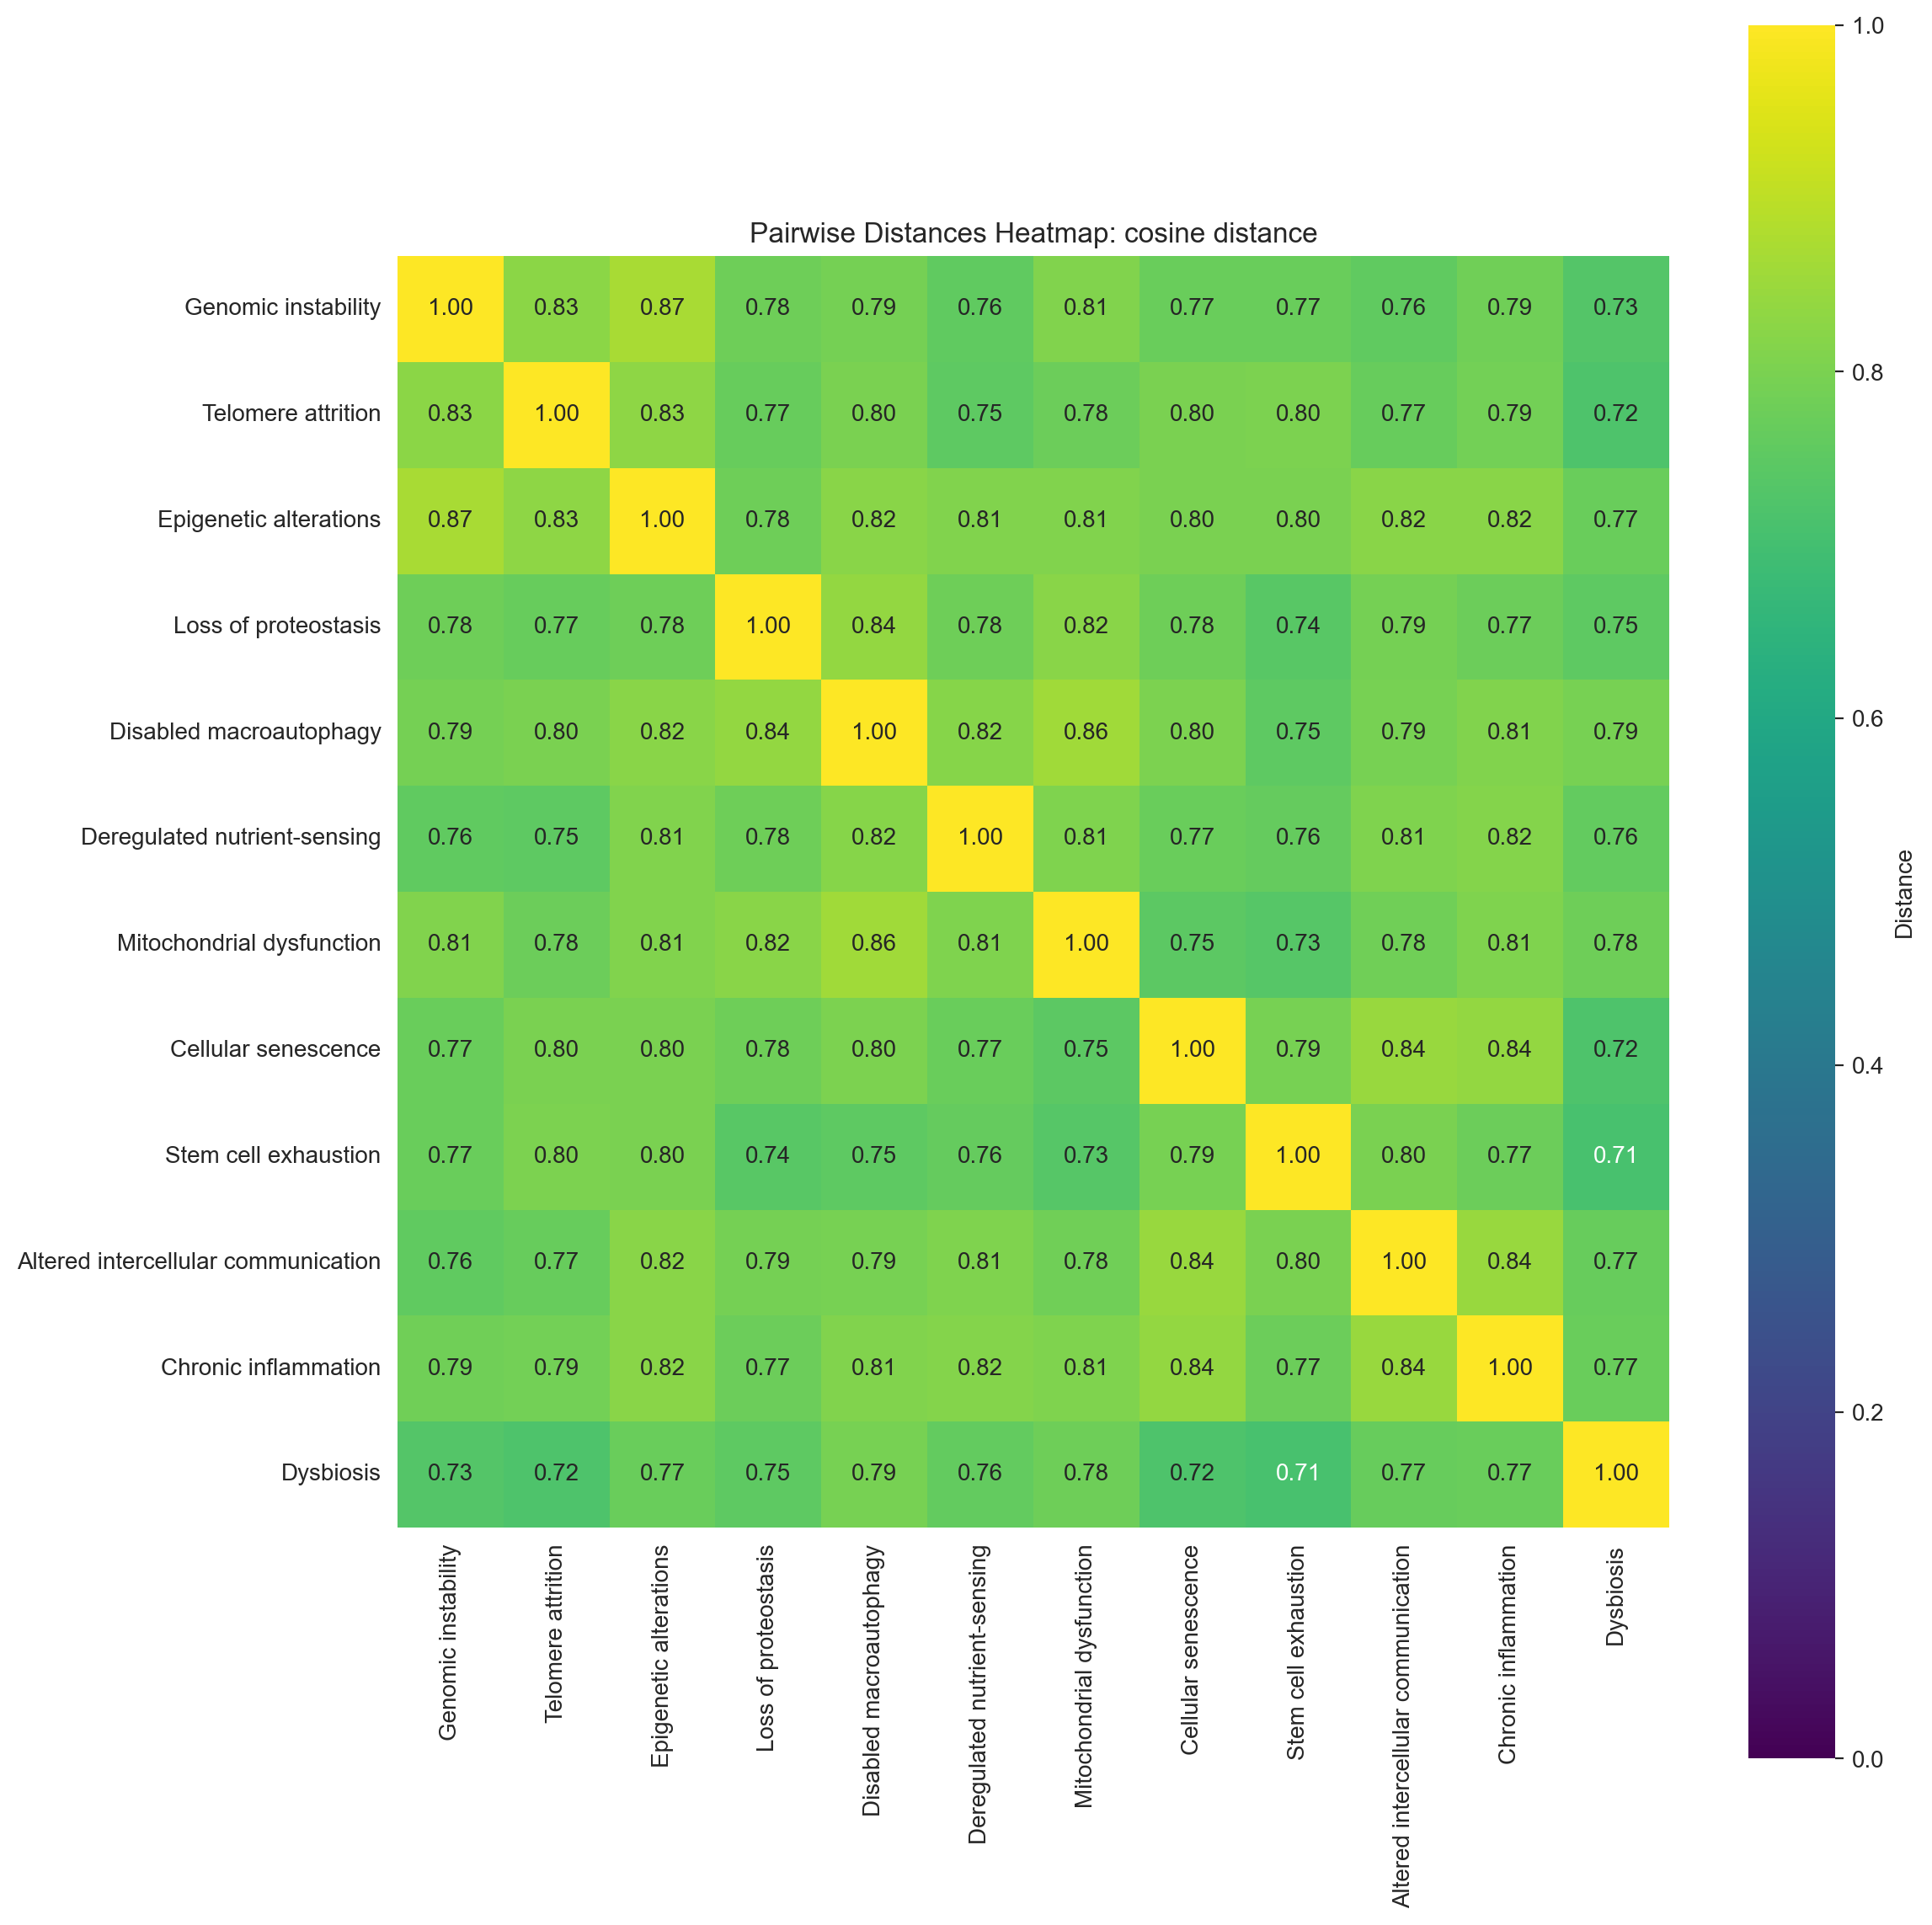

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming paired_dists is already a DataFrame
# with index and columns = keys

plt.figure(figsize=(12, 12))
sns.heatmap(paired_dists,
            cmap="viridis",        # or 'coolwarm', 'magma', etc.
            annot=True,            # shows actual values
            fmt=".2f",             # format decimal precision
            square=True,           # make cells square
            cbar_kws={"label": "Distance"},
            vmin=0, vmax=1         # fix scale to 0–1
           )
plt.title(f"Pairwise Distances Heatmap: {'cosine distance' if dist_fun_cosine else 'euclidean distance'}")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Load Request result as JSON Data

## Utils

In [124]:
import numpy as np
from numpy.linalg import norm

def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

def euclidean_distance(vec1, vec2):
    return np.linalg.norm(np.array(vec1) - np.array(vec2))


In [ ]:
def filter_by_connectivity(df, graph, percentile=75, preferred_count=None):
    # Step 1: Compute connectivity (without modifying df)
    connectivity = df['id'].apply(lambda pid: len(list(graph.neighbors(pid))))

    # Step 2: Compute the percentile threshold
    if len(df) <= preferred_count:
        # If few elements => TAKE all
        threshold = np.nanmin(connectivity)
    else:
        # If need to limit => limit by percentile, but not lower than preferred_count
        threshold = min(np.percentile(connectivity, percentile), sorted(connectivity, reverse=True)[preferred_count - 1])

    # Step 3: Get mask for nodes above threshold
    # print(f"len(df) = {len(df)}, threshold = {threshold}, {percentile}-th : {np.percentile(connectivity, percentile)}")
    # print(sorted(connectivity, reverse=True))
    # print("---")

    above_threshold_mask = connectivity >= threshold

    # Step 4: Apply the mask
    filtered_df = df[above_threshold_mask].copy()
    filtered_df['connections'] = connectivity[above_threshold_mask].values

    # Step 5: If max_count is specified, take top N by connections
    if (preferred_count is not None) and len(filtered_df) > preferred_count:
        filtered_df = filtered_df.sort_values('connections', ascending=False).head(preferred_count)

    return filtered_df

### Prompt impl

In [167]:
from google import genai
from google.genai import types
import base64

def generate(
        instructions_set, text_to_summarize,
        *,
        temperature = 1.5, top_p = 0.95, top_k=None, max_output_tokens = 8192,
        model="gemini-2.0-flash-001", thinking_budget=None, # 24447
        debug=False,
        max_retries=5
):
  client = genai.Client(
      vertexai=True,
      project=VERTEX_CLIENT_PROJECT,
      location="us-central1",
  )

  msg1_text1 = types.Part.from_text(text=text_to_summarize)
  si_text1 = instructions_set

  # model = "gemini-2.0-flash-lite-001"
  # model = "gemini-2.0-flash-001"
  contents = [types.Content(role="user", parts=[msg1_text1])]

  optional_args = {}
  if thinking_budget is not None:
      optional_args['thinking_config']=types.ThinkingConfig(thinking_budget=thinking_budget)

  generate_content_config = types.GenerateContentConfig(
    temperature = temperature,
    top_p = top_p,
    top_k = top_k,
    seed=0,
    max_output_tokens = max_output_tokens,
    response_modalities = ["TEXT"],
    safety_settings = [types.SafetySetting(
      category="HARM_CATEGORY_HATE_SPEECH",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_DANGEROUS_CONTENT",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_SEXUALLY_EXPLICIT",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_HARASSMENT",
      threshold="OFF"
    )],
    system_instruction=[types.Part.from_text(text=si_text1)],
    **optional_args
  )

  retries_cnt = 0
  while retries_cnt < max_retries:
      chunks = []
      retries_cnt += 1

      for chunk in client.models.generate_content_stream(
              model=model,
              contents=contents,
              config=generate_content_config,
      ):
          assert chunk is not None
          if chunk.text is None:
              # when chunk.text is None - smth goes wrong - XXX: is know bug in 2.5 ==> REDO
              chunks = None
              break

          if debug:
              print("CHUNK: [", chunk.text, end="]\n")

          if chunk.text is not None:
              chunks.append(chunk.text)

      # join chunks:
      if chunks is None:
          print("Retry...")
          continue

      return "".join(chunks)

  raise Exception("Cannot summarize text. Maximum number of retries reached")

## Load data

In [28]:
# Open and load the JSON file
# with open(file_path, 'r', encoding='utf-8') as file:
with gzip.open(file_path, 'rt') as file:
    json_data = json.load(file)

In [29]:
data = AnalysisData.from_json(json_data)

/Users/romeo/mambaforge/envs/pubtrends/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [30]:
pubmed_cluster_names = data.df.comp.unique()

In [31]:
pubmed_cluster_names[0]

3

In [32]:
data.df[data.df.comp == 5]

,id,title,abstract,year,type,keywords,mesh,doi,aux,authors,...,2020,2021,2022,2023,2024,2025,total,x,y,comp
20,19053174,Senescence-associated secretory phenotypes rev...,Cellular senescence suppresses cancer by arres...,2008,ClinicalTrial,,"Adult,Aging,Antineoplastic Agents therapeutic ...",10.1371/journal.pbio.0060301,"{'authors': [{'name': 'Copp JP', 'affiliation'...","Copp JP, Patil CK, Rodier F, Sun Y, Muoz DP, G...",...,212,221,242,215,249,133,2257,-27.986469,5.305854,5
26,22048312,Clearance of p16Ink4a-positive senescent cells...,Advanced age is the main risk factor for most ...,2011,Article,,Adipose Tissue cytology drug effects pathology...,10.1038/nature10600,"{'authors': [{'name': 'Baker DJ', 'affiliation...","Baker DJ, Wijshake T, Tchkonia T, LeBrasseur N...",...,205,189,203,217,238,165,2034,-30.396633,-1.208504,5
38,12939617,Small molecule activators of sirtuins extend S...,"In diverse organisms, calorie restriction slow...",2003,Article,,"Acetylation drug effects,Caloric Restriction,C...",10.1038/nature01960,"{'authors': [{'name': 'Howitz KT', 'affiliatio...","Howitz KT, Bitterman KJ, Cohen HY, Lamming DW,...",...,81,72,81,47,67,36,1485,-37.894550,-1.029929,5
49,25754370,The Achilles' heel of senescent cells: from tr...,The healthspan of mice is enhanced by killing ...,2015,Article,"PI3K delta,dasatinib,dependence receptors,ephr...","Adipocytes drug effects metabolism pathology,A...",10.1111/acel.12344,"{'authors': [{'name': 'Zhu Y', 'affiliation': ...","Zhu Y, Tchkonia T, Pirtskhalava T, Gower AC, D...",...,135,157,188,163,233,159,1296,-31.501280,-1.273779,5
59,29988130,Senolytics improve physical function and incre...,"Physical function declines in old age, portend...",2018,Article,,"Adipose Tissue metabolism,Animals,Cell Transpl...",10.1038/s41591-018-0092-9,"{'authors': [{'name': 'Xu M', 'affiliation': [...","Xu M, Pirtskhalava T, Farr JN, Weigand BM, Pal...",...,143,176,188,179,247,153,1196,-29.761129,-0.302508,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,25751060,MicroRNA-188 regulates age-related switch betw...,Bone marrow mesenchymal stem cells (BMSCs) exh...,2015,Article,,"3' Untranslated Regions genetics,Adipocytes cy...",10.1172/JCI77716,"{'authors': [{'name': 'Li CJ', 'affiliation': ...","Li CJ, Cheng P, Liang MK, Chen YS, Lu Q, Wang ...",...,41,56,40,34,22,10,287,-23.422129,4.295320,5
961,27304509,"Effects of Sex, Strain, and Energy Intake on H...",Calorie restriction (CR) is the most robust no...,2016,Article,,"Aging genetics metabolism,Animals,Autophagy ge...",10.1016/j.cmet.2016.05.027,"{'authors': [{'name': 'Mitchell SJ', 'affiliat...","Mitchell SJ, Madrigal-Matute J, Scheibye-Knuds...",...,40,41,42,25,34,22,284,-31.182007,-5.056111,5
964,27784770,Gram-negative bacterial molecules associate wi...,We determined whether Gram-negative bacterial ...,2016,Article,,"Aged,Aged 80 and over,Alzheimer Disease metabo...",10.1212/WNL.0000000000003391,"{'authors': [{'name': 'Zhan X', 'affiliation':...","Zhan X, Stamova B, Jin LW, DeCarli C, Phinney ...",...,39,52,40,28,40,36,284,-19.938992,-13.647978,5
978,12374852,"SIRT3, a human SIR2 homologue, is an NAD-depen...",The SIR2 (silent information regulator 2) gene...,2002,Article,,"Amino Acid Sequence,Animals,Base Sequence,COS ...",10.1073/pnas.222538099,"{'authors': [{'name': 'Onyango P', 'affiliatio...","Onyango P, Celic I, McCaffery JM, Boeke JD, Fe...",...,23,17,22,18,14,9,281,-40.622429,0.538324,5


In [ ]:
file_path = "/Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-human-aging-most-cited-1000.json.gz"
# file_path = "/Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-hallmarks-of-aging-an-expanding-universe.json.gz"
# file_path = "/Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-drug-resistance-in-cancer.json.gz"
# file_path = "/Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-fibrosis-from-mechanisms-to-medicines.json.gz"

## Plot

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
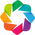

In [33]:
from pysrc.papers.plot.plotter import get_topics_description, Plotter

In [34]:
topics_description = get_topics_description(
    data.df,
    data.corpus, data.corpus_tokens, data.corpus_counts,
    n_words=5 #config.topic_description_words,
)
topics_description

{0: [('level', 5.106182249278788),
  ('diabetes', 4.861963334177318),
  ('sleep', 4.849976400809055),
  ('subjective', 4.789440252187603),
  ('body', 4.76505563382068)],
 1: [('cell', 6.652766171886299),
  ('stemness', 5.2250494214349885),
  ('expression', 5.102142582762099),
  ('immunology', 5.071691251373096),
  ('bone', 4.6995861336965845)],
 2: [('health', 6.308863365088769),
  ('country', 5.649153149171866),
  ('mortality', 5.637127104725948),
  ('globale', 5.495713942929001),
  ('behavioral', 5.483861301768826)],
 3: [('infected', 6.402308340265449),
  ('vaccine', 6.10040378247092),
  ('viruses', 5.69605676102384),
  ('virology', 5.400815988131029),
  ('virally', 5.255120391104526)],
 4: [('mutate', 5.455475850314656),
  ('genetic', 5.316236929643452),
  ('methylated', 5.177540720469551),
  ('genome', 5.0553043472646095),
  ('gene', 4.390465585777605)],
 5: [('mitochondrial', 5.057460356145214),
  ('proteins', 5.027172864708064),
  ('metabolic', 4.90274015067979),
  ('pharmacolog

In [114]:
fig = Plotter._plot_papers_graph(
        data.search_ids,
        "Pubmed", #source,
        data.papers_graph, data.df,
        5, # config.topic_description_words,
        shown_pid=None, #pid,
        topics_tags=topics_description
)

# TODO: doesn't work here
# show(fig)

## Process topic: Filter abstracts for summary

In [115]:
# topic_name = 1
# topic_name = 2
# topic_name = 5
topic_name = 3

In [105]:
highly_connected_df = filter_by_connectivity(
    data.df[data.df.comp == topic_name],
    data.papers_graph,
    percentile=5,
    max_count=200  # cap the result if it's too large
)

len(df) = 66, threshold = 7, 5-th : 13.0
[31, 31, 30, 30, 29, 27, 27, 27, 26, 26, 26, 26, 25, 25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 23, 23, 23, 23, 22, 22, 22, 21, 21, 21, 21, 21, 21, 20, 20, 20, 20, 19, 19, 19, 19, 19, 18, 18, 17, 17, 17, 16, 16, 16, 15, 15, 14, 13, 13, 13, 10, 7]
---


In [40]:
highly_connected_df

,id,title,abstract,year,type,keywords,mesh,doi,aux,authors,...,2021,2022,2023,2024,2025,total,x,y,comp,connections
5,11832223,Whole brain segmentation: automated labeling o...,We present a technique for automatically assig...,2002,Article,,"Aged,Alzheimer Disease diagnosis pathology,Bra...",10.1016/s0896-6273(02)00569-x,"{'authors': [{'name': 'Fischl B', 'affiliation...","Fischl B, Salat DH, Busa E, Albert M, Dieteric...",...,423,393,389,541,342,5035,3.007896,-27.955631,6,24
15,27437579,A multi-modal parcellation of human cerebral c...,Understanding the amazingly complex human cere...,2016,Article,,"Adult,Cerebral Cortex anatomy & histology cyto...",10.1038/nature18933,"{'authors': [{'name': 'Glasser MF', 'affiliati...","Glasser MF, Coalson TS, Robinson EC, Hacker CD...",...,293,298,343,476,294,2421,6.911473,-28.865967,6,28
18,15148381,Dynamic mapping of human cortical development ...,We report the dynamic anatomical sequence of h...,2004,Article,,"Adolescent,Adult,Aging physiology,Cerebral Cor...",10.1073/pnas.0402680101,"{'authors': [{'name': 'Gogtay N', 'affiliation...","Gogtay N, Giedd JN, Lusk L, Hayashi KM, Greens...",...,149,129,103,133,64,2331,1.916733,-28.232075,6,23
27,23861951,BrainNet Viewer: a network visualization tool ...,The human brain is a complex system whose topo...,2013,Article,,"Algorithms,Brain anatomy & histology physiolog...",10.1371/journal.pone.0068910,"{'authors': [{'name': 'Xia M', 'affiliation': ...","Xia M, Wang J, He Y",...,223,244,205,227,206,1987,9.402888,-28.943350,6,23
29,11525331,A voxel-based morphometric study of ageing in ...,Voxel-based-morphometry (VBM) is a whole-brain...,2001,Article,,"Adolescent,Adult,Aged,Aging physiology,Atrophy...",10.1006/nimg.2001.0786,"{'authors': [{'name': 'Good CD', 'affiliation'...","Good CD, Johnsrude IS, Ashburner J, Henson RN,...",...,104,89,62,60,25,1908,2.465652,-30.851675,6,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,10724172,Growth patterns in the developing brain detect...,The dynamic nature of growth and degenerative ...,2000,Article,,"Adolescent,Brain growth & development,Brain Ma...",10.1038/35004593,"{'authors': [{'name': 'Thompson PM', 'affiliat...","Thompson PM, Giedd JN, Woods RP, MacDonald D, ...",...,9,5,7,4,3,284,2.650666,-29.826382,6,23
976,27618300,Toward a Differential Diagnosis of Hidden Hear...,Recent work suggests that hair cells are not t...,2016,Article,,"Adolescent,Adult,Audiometry,Diagnosis Differen...",10.1371/journal.pone.0162726,"{'authors': [{'name': 'Liberman MC', 'affiliat...","Liberman MC, Epstein MJ, Cleveland SS, Wang H,...",...,33,46,26,33,24,282,-1.329465,-27.932295,6,6
980,21975588,Altered functional-structural coupling of larg...,The human brain is a large-scale integrated ne...,2011,Article,,"Adolescent,Adult,Brain physiopathology,Brain M...",10.1093/brain/awr223,"{'authors': [{'name': 'Zhang Z', 'affiliation'...","Zhang Z, Liao W, Chen H, Mantini D, Ding JR, X...",...,34,16,23,24,13,281,4.402020,-27.966202,6,17
986,28479476,High-resolution magnetic resonance imaging rev...,The amygdala is composed of multiple nuclei wi...,2017,Article,"Alzheimer's,Amygdala,Atlas,Autism,Ex vivo,Medi...","Aged,Aged 80 and over,Alzheimer Disease diagno...",10.1016/j.neuroimage.2017.04.046,"{'authors': [{'name': 'Saygin ZM', 'affiliatio...","Saygin ZM, Kliemann D, Iglesias JE, van der Ko...",...,33,40,41,81,34,280,3.844867,-28.630989,6,16


In [41]:
abstract_entries = highly_connected_df[['id', 'abstract']].to_dict(orient='records')

# Convert to formatted string for LLM
json_text = json.dumps(abstract_entries, ensure_ascii=False, indent=2)

output_path = f'{file_path}_highly_connected_abstracts.TOPIC-{topic_name}.json'
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(json_text)

print(f"[DONE]: {output_path}")

[DONE]: /Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-human-aging-most-cited-1000.json.gz_highly_connected_abstracts.TOPIC-6.json


## Prompt Options

In [13]:
instuction_sets = {}

In [14]:
instuction_set_1 = """
You are a research bot, tasked with helping scientific researchers to explore scientific papers quicker. Your job is to summarize the text submitted to you.

Be sure to:
* keep your summary under 400 words
* structure text
* focus on the main points of the text, formulate up to 10 main points
* keep it condense and to the point
* do not hallucinate"""

instuction_sets["instuction_set_1"] = instuction_set_1

In [15]:
instuction_set_2 = """
You are a research bot, tasked with helping scientific researchers to explore scientific papers quicker. Your job is to summarize the text submitted to you.

Be sure to:
* make a representative short title for the summary
* keep your summary under 400 words
* tell as a story where each sentence is logically connected with previous
* focus on the main points of the text
* keep it condense and to the point
* do not hallucinate"""

instuction_sets["instuction_set_2"] = instuction_set_2
# * include abstract 'id'  for point taken from such abstracts

In [16]:
instuction_set_3 = """
You are a research bot, tasked with helping scientific researchers to explore scientific papers quicker. Your job is to summarize the text submitted to you.

Be sure to:
* make a representative and short title for the summary
* keep your summary under 400 words
* tell as a story where each sentence is logically connected with previous
* focus on the main points of the text
* keep it condense and to the point
* submitted text is set of block, each block marked with own ID, it is the line in the block starting from PMID= prefix
* if some sentence from summary is based on information from one or more blocks, specify at the end of this sentence block IDs used to generate the sentence
* do not hallucinate

<EXCEPTION>
do not put by NO MEANS short sentences like ....
</EXCEPTION>
"""

instuction_sets["instuction_set_3"] = instuction_set_3
# * include abstract 'id'  for point taken from such abstracts

In [159]:
instuction_sets["instuction_set_4"] = """
You are a research bot, tasked with helping scientific researchers to explore scientific papers quicker. Your job is to summarize the text submitted to you.

Be sure to:
* make a representative and short title for the summary
* NEVER make summary longer than 400 words
* tell as a story where each sentence are ALWAYS logically connected with previous
* put by NO MEANS short sentences that are not logically connected
* focus on the main points of the text
* keep it condense and to the point
* submitted text is set of block, each block marked with own ID, it is the line in the block starting from PMID= prefix
* if some sentence from summary is based on information from one or more blocks, specify at the end of this sentence block IDs used to generate the sentence
* Organize block IDs as coma-separated list in round brackets, e.g  (PMID=0000001, PMID=11111111, PMID=777777)
* do not hallucinate, please never hallucinate

<EXCEPTION>
do not put by NO MEANS short sentences like below:

**Comprehensive Analysis of Aging Mechanisms and Potential Interventions**

Aging leads to various cellular and molecular changes, contributing to age-related diseases and functional decline. Several studies explore these mechanisms and potential interventions.

One study found that Procyanidin C1 (PCC1), a compound with senolytic and senomorphic properties, counteracts aging-related changes in the hematopoietic and immune system by improving physiological parameters, increasing B cells and hematopoietic stem cells, suppressing senescence markers, and restoring immune homeostasis. PMID=40316527

Skeletal muscle deterioration, a hallmark of aging, involves reduced SIRT5 expression, leading to cellular senescence and inflammation; SIRT5 desuccinylates TBK1, suppressing inflammation and improving muscle function, suggesting the SIRT5-TBK1 pathway as a target for combating age-related muscle degeneration. PMID=40087407

Endothelial cell senescence, resulting from telomerase inactivation, induces transcriptional changes indicative of senescence and tissue hypoxia, compromising the blood-brain barrier and reducing muscle endurance, indicating that Tert loss causes EC senescence through a telomere length-independent mechanism undermining mitochondrial function. PMID=38475941

Blood-borne factors like osteocalcin (OCN) are crucial for maintaining neuronal synaptic plasticity, and OCN's effects are mediated by a primary cilium (PC) protein-autophagy axis; during aging, autophagy and PC core proteins are reduced, and restoring their levels improves cognitive impairments, suggesting the PC-autophagy axis as a gateway for communication between blood-borne factors and neurons. PMID=39984747

Mitochondrial dysfunction is a key aging determinant, and defects in mitochondrial protein and organelle quality control have been linked to various age-related diseases. PMID=37731280

Hyperactivation of mTORC1 signaling with aging contributes to cardiac dysfunction by dysregulating proteostasis, as shown in a 4EBP1 KO mouse model mimicking a hyperactive mTORC1/4EBP1/eIF4E axis. PMID=39379739

Dietary protein, particularly branched-chain amino acids (BCAAs), influences healthy aging; BCAA restriction protects against metabolic consequences of high protein diets and has tissue-specific effects on cellular senescence. PMID=39868338

Macroautophagy decreases with age, but mitophagy, the selective autophagic degradation of mitochondria, may increase or remain unchanged; pharmacological induction of mitophagy attenuates inflammation and ameliorates neurological function, pointing to mitophagy induction as a strategy to decrease age-associated inflammation. PMID=38280852

PGC-1, a mitochondrial regulator, is repressed with aging in the brain and is integral in coordinating metabolism and growth signaling, placing it centrally in a growth and metabolism network relevant to brain aging. PMID=40021651

Apigenin, a bioactive plant compound, may protect against age-related cognitive dysfunction by suppressing neuro-inflammatory processes driven by glial cells. PMID=38007051

Inhibition of mitochondrial malate dehydrogenase (MDH2) delays the aging process through metabolic-epigenetic regulation, identifying MDH2 as a potential therapeutic target for anti-aging drug development. PMID=39962087

The SATB protein DVE-1 influences lifespan independent of its canonical mitoUPR function, suggesting broader functions in modulating longevity and defending against stress. PMID=39423131

TFEB deficiency in the proximal tubules causes metabolic disorders and mitochondrial dysfunction, shedding light on the mechanisms of APOA4 amyloidosis pathogenesis and providing a therapeutic strategy for CKD-related metabolic disorders. PMID=39699959

β-hydroxybutyrate (HB), a ketone body, regulates protein solubility, selectively targeting pathological proteins like amyloid-β, suggesting a metabolically regulated mechanism of proteostasis relevant to aging and Alzheimer's disease. PMID=39626664

LRP5 promotes lower-body fat distribution and enhances insulin sensitivity, independent of its bone-related functions, and its activation may prevent age-related fat redistribution and metabolic disorders. PMID=40000740

Aging promotes STAT1 β-hydroxybutyrylation, attenuating IFN-I-mediated antiviral defense activity, and fructose can improve IFN-I antiviral defense activity by orchestrating STAT1 O-GlcNAc and β-hydroxybutyrylation modifications. PMID=39979583

HIRA and PML are essential for SASP expression, activating SASP through a CCF-cGAS-STING-TBK1-NF-κB pathway. PMID=39178863

TMEM242 depletion impairs ATP synthase, elevates ROS, upregulates sirt6 and nrf2, and increases f9a transcripts, potentially leading to bleeding tendencies. PMID=39856164

A disease-causing mutation of ABCA6 is identified for FPD, and ABCA6 is correlated with PD occurrence and subsequent OA progression, serving as a potential target in chondrogenesis and OA treatment by orchestrated intracellular cholesterol efflux and delayed cellular senescence. PMID=39823538

Endogenous DNA damage promotes hallmarks of age-related retinal degeneration, as shown in Ercc1-/- mice, which model a human progeroid syndrome. PMID=39604117

ACSS2 promotes the acetylation of PAICS, limiting purine metabolism and exacerbating cytoplasmic chromatin fragment accumulation and SASP, identifying ACSS2 as a potential senomorphic target to prevent senescence-associated diseases. PMID=40021646

SPP1 activates ITG5/1 to inhibit mitophagy, accelerates NPs degeneration, and induces calcification, leading to intervertebral disc degeneration (IVDD) and calcification. PMID=39721032

STXBP5 overexpression accelerates senescence, while STXBP5 deletion suppresses progerin expression, delaying senility, and decreasing the expression of senescence-related factors. PMID=39379476

Compartment-targeted FlucDM sensors pinpoint a diverse modulation of subcellular proteostasis by aging regulators. PMID=39383859

IGF-1 signaling plays a crucial role in preserving a youthful cerebromicrovascular endothelial phenotype and maintaining the integrity of the BBB. PMID=38082450

Aged hippocampal mitochondria exhibit impaired bioenergetic function, increased ROS production, deregulation of calcium homeostasis, and decreased mitochondrial biogenesis. PMID=36982549

TBK1-ATAD3A-Pink1 axis drives cellular senescence, suggesting a potential mitochondrial target for anti-aging therapy. PMID=39520088

Aging causes widespread reduction of proteins enriched in basic amino acids that is independent of mRNA regulation, and aberrant translation pausing leads to reduced ribosome availability resulting in proteome remodeling. PMID=38260253

Cysteine oxidation of muscle proteins impairs muscle power and strength, walking speed, and cardiopulmonary fitness with aging. PMID=38332629

CUL2FEM1B senses ROS produced by complex III of the electron transport chain (ETC), helping cells adjust their ETC to changing environments. PMID=39642856

HSF-1 mediates lifespan extension through mitochondrial network adaptations that occur in response to down-tuning of components associated with organellar protein degradation pathways. PMID=39532882

YBR238C oppositely affect mitochondria and aging, modulating mitochondrial function, demonstrating a feedback loop between TORC1 and mitochondria (the TORC1-MItochondria-TORC1 (TOMITO) signaling process) that regulates cellular aging processes. PMID=38713053

Mitochondrial metabolic modulation contributes to the longevity of daf-2 mutants, highlighting the crucial role of mitochondria in aging. PMID=40136535

MAVS safeguards mitochondrial homeostasis and antagonizes human stem cell senescence. PMID=37521327

TMEM135 is crucial for regulating mitochondria, peroxisomes, and lipids, emphasizing the importance of a balanced TMEM135 function for the health of the retina and other tissues. PMID=38576540

Blocking neddylation increased cellular hallmarks of aging and led to an increase in Tau aggregation and phosphorylation in neurons carrying the APPswe/swe mutation, indicating that cellular aging can reveal late-onset disease phenotypes. PMID=38917806

Mitochondrial DNA turnover in rat skeletal muscle decreases with age, contributing to losses of mitochondrial genomic integrity and potentially playing a role in skeletal muscle dysfunction. PMID=39312152

Suppression of NF-κB in cardiomyocytes leads to pronounced cardiac remodeling, dysfunction, and cellular damage associated with the aging process, influencing both cellular senescence and molecular damage pathways. PMID=39857807

MicroRNAs and neuropeptide-like proteins can form molecular regulatory networks involving downstream molecules to regulate lifespan, and such regulatory effects vary on environmental conditions. PMID=39323014

Pharmacological elevation of CISD2 expression at a late-life stage using hesperetin treatment is a feasible approach to effectively mitigating both intrinsic and extrinsic skin aging. PMID=38263133

Oxidative protein folding in the ER promotes cell aging, providing a potential target for aging and aging-related disease intervention. PMID=37306027

Mitochondrial morphology changes during aging, and C. elegans serve as a robust model for rapidly measuring mitochondrial

* Do not put same PMID in the one coma-separated list, like below:

Yin-Chen-Hao-Tang (YCHT) exhibited anti-fibrotic effects on the liver, potentially by suppressing oxidative stress and lipid peroxidation, restoring levels of metabolites like unsaturated fatty acids and lysophosphatidylcholines (PMID=26805802). Sophora flavescens (Kushen) itself showed anti-fibrosis activity, with studies identifying potential active compounds and targets through integrated network pharmacology and biomedical analysis (PMID=27754507). Fufang Biejia Ruangan Pill (FFBJ), an approved anti-fibrosis drug, contains various components including organic acids, terpenoids, flavonoids, phenylpropanoids, and alkaloids, with studies identifying absorbed components in vivo to understand its material basis (PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854,

</EXCEPTION>
"""


# * include abstract 'id'  for point taken from such abstracts

In [ ]:
instuction_sets["instuction_set_5"] = """
You are a research bot, tasked with helping scientific researchers to explore scientific papers quicker. Your job is to summarize the text submitted to you.

Be sure to:
* make a representative and short title for the summary
* NEVER make summary longer than 400 words
* tell as a story where each sentence are ALWAYS logically connected with previous
* put by NO MEANS short sentences that are not logically connected
* focus on the main points of the text
* keep it condense and to the point
* submitted text is set of block, each block marked with own ID, it is the line in the block starting from PMID= prefix
* if some sentence from summary is based on information from one or more blocks, specify at the end of this sentence block IDs used to generate the sentence
* Organize block IDs as coma-separated list in round brackets, e.g  (PMID=0000001, PMID=11111111, PMID=777777)
* do not hallucinate, please never hallucinate

<EXCEPTION>
do not put by NO MEANS short sentences like below:

**Comprehensive Analysis of Aging Mechanisms and Potential Interventions**

Aging leads to various cellular and molecular changes, contributing to age-related diseases and functional decline. Several studies explore these mechanisms and potential interventions.

One study found that Procyanidin C1 (PCC1), a compound with senolytic and senomorphic properties, counteracts aging-related changes in the hematopoietic and immune system by improving physiological parameters, increasing B cells and hematopoietic stem cells, suppressing senescence markers, and restoring immune homeostasis. PMID=40316527

Skeletal muscle deterioration, a hallmark of aging, involves reduced SIRT5 expression, leading to cellular senescence and inflammation; SIRT5 desuccinylates TBK1, suppressing inflammation and improving muscle function, suggesting the SIRT5-TBK1 pathway as a target for combating age-related muscle degeneration. PMID=40087407

Endothelial cell senescence, resulting from telomerase inactivation, induces transcriptional changes indicative of senescence and tissue hypoxia, compromising the blood-brain barrier and reducing muscle endurance, indicating that Tert loss causes EC senescence through a telomere length-independent mechanism undermining mitochondrial function. PMID=38475941

Blood-borne factors like osteocalcin (OCN) are crucial for maintaining neuronal synaptic plasticity, and OCN's effects are mediated by a primary cilium (PC) protein-autophagy axis; during aging, autophagy and PC core proteins are reduced, and restoring their levels improves cognitive impairments, suggesting the PC-autophagy axis as a gateway for communication between blood-borne factors and neurons. PMID=39984747

Mitochondrial dysfunction is a key aging determinant, and defects in mitochondrial protein and organelle quality control have been linked to various age-related diseases. PMID=37731280

Hyperactivation of mTORC1 signaling with aging contributes to cardiac dysfunction by dysregulating proteostasis, as shown in a 4EBP1 KO mouse model mimicking a hyperactive mTORC1/4EBP1/eIF4E axis. PMID=39379739

Dietary protein, particularly branched-chain amino acids (BCAAs), influences healthy aging; BCAA restriction protects against metabolic consequences of high protein diets and has tissue-specific effects on cellular senescence. PMID=39868338

Macroautophagy decreases with age, but mitophagy, the selective autophagic degradation of mitochondria, may increase or remain unchanged; pharmacological induction of mitophagy attenuates inflammation and ameliorates neurological function, pointing to mitophagy induction as a strategy to decrease age-associated inflammation. PMID=38280852

PGC-1, a mitochondrial regulator, is repressed with aging in the brain and is integral in coordinating metabolism and growth signaling, placing it centrally in a growth and metabolism network relevant to brain aging. PMID=40021651

Apigenin, a bioactive plant compound, may protect against age-related cognitive dysfunction by suppressing neuro-inflammatory processes driven by glial cells. PMID=38007051

Inhibition of mitochondrial malate dehydrogenase (MDH2) delays the aging process through metabolic-epigenetic regulation, identifying MDH2 as a potential therapeutic target for anti-aging drug development. PMID=39962087

The SATB protein DVE-1 influences lifespan independent of its canonical mitoUPR function, suggesting broader functions in modulating longevity and defending against stress. PMID=39423131

TFEB deficiency in the proximal tubules causes metabolic disorders and mitochondrial dysfunction, shedding light on the mechanisms of APOA4 amyloidosis pathogenesis and providing a therapeutic strategy for CKD-related metabolic disorders. PMID=39699959

β-hydroxybutyrate (HB), a ketone body, regulates protein solubility, selectively targeting pathological proteins like amyloid-β, suggesting a metabolically regulated mechanism of proteostasis relevant to aging and Alzheimer's disease. PMID=39626664

LRP5 promotes lower-body fat distribution and enhances insulin sensitivity, independent of its bone-related functions, and its activation may prevent age-related fat redistribution and metabolic disorders. PMID=40000740

Aging promotes STAT1 β-hydroxybutyrylation, attenuating IFN-I-mediated antiviral defense activity, and fructose can improve IFN-I antiviral defense activity by orchestrating STAT1 O-GlcNAc and β-hydroxybutyrylation modifications. PMID=39979583

HIRA and PML are essential for SASP expression, activating SASP through a CCF-cGAS-STING-TBK1-NF-κB pathway. PMID=39178863

TMEM242 depletion impairs ATP synthase, elevates ROS, upregulates sirt6 and nrf2, and increases f9a transcripts, potentially leading to bleeding tendencies. PMID=39856164

A disease-causing mutation of ABCA6 is identified for FPD, and ABCA6 is correlated with PD occurrence and subsequent OA progression, serving as a potential target in chondrogenesis and OA treatment by orchestrated intracellular cholesterol efflux and delayed cellular senescence. PMID=39823538

Endogenous DNA damage promotes hallmarks of age-related retinal degeneration, as shown in Ercc1-/- mice, which model a human progeroid syndrome. PMID=39604117

ACSS2 promotes the acetylation of PAICS, limiting purine metabolism and exacerbating cytoplasmic chromatin fragment accumulation and SASP, identifying ACSS2 as a potential senomorphic target to prevent senescence-associated diseases. PMID=40021646

SPP1 activates ITG5/1 to inhibit mitophagy, accelerates NPs degeneration, and induces calcification, leading to intervertebral disc degeneration (IVDD) and calcification. PMID=39721032

STXBP5 overexpression accelerates senescence, while STXBP5 deletion suppresses progerin expression, delaying senility, and decreasing the expression of senescence-related factors. PMID=39379476

Compartment-targeted FlucDM sensors pinpoint a diverse modulation of subcellular proteostasis by aging regulators. PMID=39383859

IGF-1 signaling plays a crucial role in preserving a youthful cerebromicrovascular endothelial phenotype and maintaining the integrity of the BBB. PMID=38082450

Aged hippocampal mitochondria exhibit impaired bioenergetic function, increased ROS production, deregulation of calcium homeostasis, and decreased mitochondrial biogenesis. PMID=36982549

TBK1-ATAD3A-Pink1 axis drives cellular senescence, suggesting a potential mitochondrial target for anti-aging therapy. PMID=39520088

Aging causes widespread reduction of proteins enriched in basic amino acids that is independent of mRNA regulation, and aberrant translation pausing leads to reduced ribosome availability resulting in proteome remodeling. PMID=38260253

Cysteine oxidation of muscle proteins impairs muscle power and strength, walking speed, and cardiopulmonary fitness with aging. PMID=38332629

CUL2FEM1B senses ROS produced by complex III of the electron transport chain (ETC), helping cells adjust their ETC to changing environments. PMID=39642856

HSF-1 mediates lifespan extension through mitochondrial network adaptations that occur in response to down-tuning of components associated with organellar protein degradation pathways. PMID=39532882

YBR238C oppositely affect mitochondria and aging, modulating mitochondrial function, demonstrating a feedback loop between TORC1 and mitochondria (the TORC1-MItochondria-TORC1 (TOMITO) signaling process) that regulates cellular aging processes. PMID=38713053

Mitochondrial metabolic modulation contributes to the longevity of daf-2 mutants, highlighting the crucial role of mitochondria in aging. PMID=40136535

MAVS safeguards mitochondrial homeostasis and antagonizes human stem cell senescence. PMID=37521327

TMEM135 is crucial for regulating mitochondria, peroxisomes, and lipids, emphasizing the importance of a balanced TMEM135 function for the health of the retina and other tissues. PMID=38576540

Blocking neddylation increased cellular hallmarks of aging and led to an increase in Tau aggregation and phosphorylation in neurons carrying the APPswe/swe mutation, indicating that cellular aging can reveal late-onset disease phenotypes. PMID=38917806

Mitochondrial DNA turnover in rat skeletal muscle decreases with age, contributing to losses of mitochondrial genomic integrity and potentially playing a role in skeletal muscle dysfunction. PMID=39312152

Suppression of NF-κB in cardiomyocytes leads to pronounced cardiac remodeling, dysfunction, and cellular damage associated with the aging process, influencing both cellular senescence and molecular damage pathways. PMID=39857807

MicroRNAs and neuropeptide-like proteins can form molecular regulatory networks involving downstream molecules to regulate lifespan, and such regulatory effects vary on environmental conditions. PMID=39323014

Pharmacological elevation of CISD2 expression at a late-life stage using hesperetin treatment is a feasible approach to effectively mitigating both intrinsic and extrinsic skin aging. PMID=38263133

Oxidative protein folding in the ER promotes cell aging, providing a potential target for aging and aging-related disease intervention. PMID=37306027

Mitochondrial morphology changes during aging, and C. elegans serve as a robust model for rapidly measuring mitochondrial

* Do not put same PMID in the one coma-separated list, like below:

Yin-Chen-Hao-Tang (YCHT) exhibited anti-fibrotic effects on the liver, potentially by suppressing oxidative stress and lipid peroxidation, restoring levels of metabolites like unsaturated fatty acids and lysophosphatidylcholines (PMID=26805802). Sophora flavescens (Kushen) itself showed anti-fibrosis activity, with studies identifying potential active compounds and targets through integrated network pharmacology and biomedical analysis (PMID=27754507). Fufang Biejia Ruangan Pill (FFBJ), an approved anti-fibrosis drug, contains various components including organic acids, terpenoids, flavonoids, phenylpropanoids, and alkaloids, with studies identifying absorbed components in vivo to understand its material basis (PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854, PMID=26724854,

</EXCEPTION>
"""


# * include abstract 'id'  for point taken from such abstracts

## Do Prompt

In [43]:
# output_path = "/Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-hallmarks-of-aging-an-expanding-universe.json.gz_highly_connected_abstracts.TOPIC-5.json"
output_path

# TODO: load from output_path:
# abstract_entries

'/Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-human-aging-most-cited-1000.json.gz_highly_connected_abstracts.TOPIC-6.json'

In [44]:
# text_to_summarize = "\n".join(e['abstract'] for e in abstract_entries)
# summary = generate(instuction_set_2, text_to_summarize)
text_to_summarize = "\n".join(f"\nPMID={e['id']}\n{e['abstract']}" for e in abstract_entries)
summary = generate(instuction_set_3, text_to_summarize)

output_path = f'{file_path}_highly_connected_abstracts.TOPIC-{topic_name}.txt'
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(summary)
print(summary)

Neuroimaging Advances in Understanding Brain Development, Aging, and Neurological Disorders

Advancements in neuroimaging techniques have significantly enhanced our understanding of brain development, aging, and neurological disorders. One such technique involves automatically assigning neuroanatomical labels to voxels in MRI volumes using probabilistic data derived from manually labeled training sets, achieving accuracy comparable to manual labeling and detecting subtle volume changes in noncortical structures indicative of Alzheimer's disease (AD) PMID:11832223. These developments also extend to mapping the human cerebral cortex, identifying 180 distinct areas per hemisphere based on multi-modal magnetic resonance images and machine learning classifiers PMID:27437579.

Longitudinal studies utilizing quantitative four-dimensional maps and time-lapse sequences have revealed the dynamic anatomical sequence of cortical gray matter development from childhood to young adulthood, showing th

In [222]:
# text_to_summarize

## Compare summary with review paper

In [245]:
summary_embedding = calc_embedding(summary)

----
# vectors 1
billable_character_count=2830


In [246]:
keys = list(topic_2_embeddings.keys())

# dist_fun_cosine = False
dist_fun_cosine = True
paired_dists = np.zeros(shape=(len(keys), len(keys)))
for i in range(len(keys)):
    emb_i = topic_2_embeddings[keys[i]]
    emb_j = summary_embedding
    if dist_fun_cosine:
        dist_fun = cosine_similarity
    else:
        dist_fun = euclidean_distance

    d = dist_fun(emb_i.embeddings[0].values, emb_j.embeddings[0].values)
    print(keys[i], d)

Genomic instability 0.7486514998491182
Telomere attrition 0.7634059693181915
Epigenetic alterations 0.7845043092874029
Loss of proteostasis 0.793377020909306
Disabled macroautophagy 0.7986335893336827
Deregulated nutrient-sensing 0.7915219672565524
Mitochondrial dysfunction 0.7824138185676719
Cellular senescence 0.8437111330175433
Stem cell exhaustion 0.7527076124654797
Altered intercellular communication 0.8107970257067989
Chronic inflammation 0.6543308004013896
Dysbiosis 0.7729255182583367
T5 0.8252555925623455
T1 0.848661266370721
T2 0.8301199829401514


In [247]:
topic_2_embeddings[f"T{topic_name}"] = summary_embedding

## All - Together

In [ ]:
attempt_single = 100
attempt = 10

In [173]:
# file_path = "/Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-human-aging-most-cited-1000.json.gz"
# file_path = "/Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-drug-resistance-in-cancer.json.gz"
# file_path = "/Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-fibrosis-from-mechanisms-to-medicines.json.gz"
file_path = "/Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-hallmarks-of-aging-an-expanding-universe.json.gz"

# Open and load the JSON file
# with open(file_path, 'r', encoding='utf-8') as file:
with gzip.open(file_path, 'rt') as file:
    json_data = json.load(file)

    data = AnalysisData.from_json(json_data)


topics_description = get_topics_description(
    data.df,
    data.corpus, data.corpus_tokens, data.corpus_counts,
    n_words=5 #config.topic_description_words,
)


/Users/romeo/mambaforge/envs/pubtrends/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [174]:
def process_topic(
        topic_name, topics_description, topic_2_embeddings, instuction_sets, *, attempt,
        max_count_per_topic=200, connectivity_percentile_thr=5,
        model, temperature, top_p, top_k, max_output_tokens, instuction_set_key, thinking_budget=None,
        debug=False
):
    print("\n")
    print(f"========================== TOPIC {topic_name} ==========================================")
    print("\n")

    filtered_df = data.df[data.df.comp == topic_name]
    highly_connected_df = filter_by_connectivity(
        filtered_df,
        data.papers_graph,
        percentile=connectivity_percentile_thr,
        preferred_count=max_count_per_topic  # cap the result if it's too large
    )
    abstract_entries = highly_connected_df[['id', 'abstract']].to_dict(orient='records')
    print(f"Highly connected papers: {len(filtered_df)} -> {len(highly_connected_df)}")

    # Convert to formatted string for LLM
    json_text = json.dumps(abstract_entries, ensure_ascii=False, indent=2)

    output_path = f'{file_path}_highly_connected_abstracts.TOPIC-{topic_name}.json'
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(json_text)

    print(f"[DONE]: {output_path}")

    print("\nCompute summary...")
    # TODO: customize
    text_to_summarize = "\n".join(f"\nPMID={e['id']}\n{e['abstract']}" for e in abstract_entries)


    summary = generate(
        instuction_sets[instuction_set_key],
        text_to_summarize,
        model=model, temperature=temperature, top_p=top_p, top_k=top_k, max_output_tokens=max_output_tokens,
        thinking_budget=thinking_budget,
        debug=debug
    )
    summary_title = summary.split("\n", 2)[0]

    topic_desc = ",".join([k for k,v in topics_description[topic_name]])
    print(f"\nCompute alt title from keywords...: {topic_desc}")
    keyword_title = generate(
        """
You are a research bot, tasked with helping scientific researchers to assign a title to scientific text about some topic using text submitted to you and submitted keywords. Your job is to summarize the scientific topic text into one sentence to you using suggested keywords.

Be sure to:
* make a representative and short title for the given text
* focus on the main points of the text
* keep it condense and to the point
* NEVER output more that one sentence
* do not hallucinate
<EXCEPTION>
do not put by NO MEANS more that one sentence. Do not highlight title as bold string. E.g not like below:
**Virally Infected Diseases and Vaccine Strategies in Virology**

This research discusses respiratory infections, including COVID-19, and HPV-associated diseases. The emergence of SARS-CoV-2 led to a global pandemic, with vaccines showing efficacy. Community-acquired pneumonia and other respiratory viruses are also discussed. HPV infection is
</EXCEPTION>
""",
        f"KEYWORDS: {topic_desc}\nTEXT:\n{summary}",

        temperature = 0.01, top_p = 0.95, top_k=None, max_output_tokens = 64,
        model="gemini-2.0-flash-lite-001"
        # model="gemini-2.5-flash-preview-04-17"
    ).strip()

    output_path = f'{file_path}_highly_connected_abstracts.TOPIC-{topic_name}.ATTEMPT-{attempt}.txt'
    with open(output_path, 'w', encoding='utf-8') as f:
        args = dict(
            model=model, temperature=temperature, top_p=top_p, top_k=top_k, max_output_tokens=max_output_tokens, thinking_budget=thinking_budget,
            max_count_per_topic=max_count_per_topic,
            connectivity_percentile_thr=connectivity_percentile_thr,
            instuction_set_key=instuction_set_key
        )
        f.write("; ".join([f"{k}={v}" for k,v in args.items()]) + "\n")
        f.write("--------------\n")
        f.write(f"KEYWORDS: {topic_desc}\n")
        f.write(f"KEYWORDS TITLE: {keyword_title}\n")
        f.write("--------------\n")
        f.write(summary)

    print(f"[DONE]: {output_path}")

    print("--------------------")
    print("[TITLE]")
    print(keyword_title)
    print("--------------------")
    print("[SUMMARY]")
    print("--------------------")
    print(summary)
    print("--------------------")

    print("\nCompute embedding...")
    summary_embedding = calc_embedding(summary)
    topic_2_embeddings[f"T{topic_name}"] = summary_embedding

    return summary, summary_title, keyword_title

In [50]:
# # Clean-up:
# for topic_name in sorted(pubmed_cluster_names):
#     key = f"T{topic_name}"
#     if key in topic_2_embeddings:
#         del topic_2_embeddings[key]

### Run: One topic

In [52]:
instuction_sets.keys()

dict_keys(['instuction_set_1', 'instuction_set_2', 'instuction_set_3', 'instuction_set_4'])

In [114]:
# filtered_df = data.df[data.df.comp == topic_name]
# highly_connected_df = filter_by_connectivity(
#     filtered_df,
#     data.papers_graph,
#     percentile=95,
#     preferred_count=130  # cap the result if it's too large
# )
# len(highly_connected_df)

In [165]:
print(attempt_single)

# topic_name = 8
topic_name = 1
# topic_name = 9

topic_desc = ",".join([k for k,v in topics_description[topic_name]])
print(topic_desc)

# summary, summary_title, keyword_title =\
process_topic(
    topic_name, topics_description, {}, instuction_sets, attempt=attempt_single,

    # model="gemini-2.0-flash-001",  temperature=0.5, top_p=0.95, top_k=None, max_output_tokens=8192, instuction_set_key='instuction_set_3',
    # model="gemini-2.0-flash-001",  temperature=1.0, top_p=0.95, top_k=None, max_output_tokens=8192, instuction_set_key='instuction_set_3',
    # model="gemini-2.0-flash-001",  temperature=1.5, top_p=0.95, top_k=None, max_output_tokens=8192, instuction_set_key='instuction_set_3',
    # model="gemini-2.0-flash-001",  temperature=1.5, top_p=0.95, top_k=20, max_output_tokens=8192,  instuction_set_key='instuction_set_3',
    # model="gemini-2.0-flash-001",  temperature=1.5, top_p=0.95, top_k=20, max_output_tokens=2048, instuction_set_key='instuction_set_3',

    # model="gemini-2.0-flash-001",  temperature=0.5, top_p=0.75, top_k=20, max_output_tokens=2048, instuction_set_key='instuction_set_3',
    # model="gemini-2.0-flash-001",  temperature=0.1, top_p=0.75, top_k=20, max_output_tokens=2048, instuction_set_key='instuction_set_3',

    # model="gemini-2.5-flash-preview-04-17",  temperature=0.1, top_p=0.75, top_k=20, max_output_tokens=2048,  instuction_set_key='instuction_set_4',thinking_budget=4447,
    # model="gemini-2.5-flash-preview-04-17",  temperature=0.1, top_p=0.75, top_k=20, max_output_tokens=8192,  instuction_set_key='instuction_set_4',thinking_budget=1000,
    # model="gemini-2.5-flash-preview-04-17",  temperature=0.1, top_p=0.75, top_k=30, max_output_tokens=8192,  instuction_set_key='instuction_set_4',thinking_budget=5000,
    # model="gemini-2.5-flash-preview-04-17",  temperature=0.1, top_p=0.75, top_k=30, max_output_tokens=8192,  instuction_set_key='instuction_set_4',thinking_budget=22000,

    # XXX: to slow, e.g. more than 1m pro topic
    model="gemini-2.5-pro-preview-05-06",  temperature=0.1, top_p=0.75, top_k=20, max_output_tokens=8192,  instuction_set_key='instuction_set_4',

    # TODO: +try 2.5-pro-preview model
    # TODO: +thinking budger - manual -> max, grounding
    # TODO: (?) deep research
    # TODO: gemeni --> improve prompt --->
    # ? papers ---> bucket
    # TODO: +low temparatures
    # TODO:  //// put smth into bucket
    # TODO: agent -> use semantic search multipl times
    #           // function calling vs vertex ai tool
    #           // lang chaun

    max_count_per_topic=150, connectivity_percentile_thr=5,
    debug=True
)
attempt_single+=1

105
mitochondrial,proteins,metabolic,muscle,mitochondrion


========================== TOPIC 1 ==========================================


Highly connected papers: 152 -> 150
[DONE]: /Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-hallmarks-of-aging-an-expanding-universe.json.gz_highly_connected_abstracts.TOPIC-1.json

Compute summary...
CHUNK: [ 
]
CHUNK: [ , therapeutic strategies targeting senescent cells, such as Procyanidin C1 (PCC1) or SGLT2 inhibitors, show promise]
CHUNK: [ 
]
CHUNK: [ *]
CHUNK: [  **Title:** Exploring Cellular Mechanisms and Therapeutic Targets in Aging and Age-Related Diseases
]
CHUNK: [ * **Summary:**
Aging is a complex process characterized by a decline in cellular and]
CHUNK: [  organ function, often leading to age-related diseases (PMID=37523061, PMID=36982549).]
CHUNK: [  Several molecular pathways and cellular components are implicated in aging, including mitochondrial dysfunction, altered proteostasis, and cellular senescence (PMID=

### Run: ALL

In [175]:
topic_2_summary = []

print("ATTEMPT: ", attempt)
pubmed_topic_2_embeddings = {}
prompt_args = dict(
    max_count_per_topic=50, connectivity_percentile_thr=50,

    # XXX: More stable:
    # model="gemini-2.0-flash-001",  temperature=0.1, top_p=0.75, top_k=30, max_output_tokens=8192,instuction_set_key='instuction_set_4',

    # XXX: Less stable, maybe better:
    model="gemini-2.5-flash-preview-04-17",  temperature=0.1, top_p=0.75, top_k=30, max_output_tokens=8192,  instuction_set_key='instuction_set_4', thinking_budget=1000
)

for topic_name in sorted(pubmed_cluster_names):

    summary, summary_title, keyword_title = process_topic(
        topic_name, topics_description, pubmed_topic_2_embeddings, instuction_sets, attempt=attempt,
        **prompt_args
    )

    title = f"{summary_title} | {keyword_title}"
    topic_2_summary.append({
        "topic": topic_name,
        "title": title,
        "summary_title": summary_title,
        "keyword_title": keyword_title,
        "summary": summary,
    })

for item in topic_2_summary:
    print(item['topic'], ": ", item['title'])

output_path = f'{os.path.dirname(file_path)}/SUMMARY.{os.path.basename(file_path)}_ATTEMPT.{attempt}.txt'
with open(output_path, 'w', encoding='utf-8') as f:
    print("; ".join([f"{k}={v}" for k,v in prompt_args.items()]), file=f)
    print("\n======================================================", file=f)

    for item in topic_2_summary:
        print(item['topic'], ": ", item['title'], file=f)

    print("\n======================================================", file=f)

    for item in topic_2_summary:
        print(f"\n------TOPIC: {item['topic']}-------------------------------------------------", file=f)
        print(f"\nKEYWORDS: {topics_description[item['topic']]}" , file=f)
        print(f"\nKEYWORD TITLE: {item['keyword_title']}" , file=f)
        print(item['summary'], file=f)
print("[DONE] ", output_path)

# ------
attempt+=1


ATTEMPT:  17


========================== TOPIC 0 ==========================================


Highly connected papers: 164 -> 50
[DONE]: /Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-hallmarks-of-aging-an-expanding-universe.json.gz_highly_connected_abstracts.TOPIC-0.json

Compute summary...

Compute alt title from keywords...: associate,risk,study,adult,biology
[DONE]: /Users/romeo/work/pubtrends_related/hackathon/json_examples/pubmed-hallmarks-of-aging-an-expanding-universe.json.gz_highly_connected_abstracts.TOPIC-0.ATTEMPT-17.txt
--------------------
[TITLE]
A study associates various biological factors and modifiable lifestyle factors with the risk of accelerated aging in adults.
--------------------
[SUMMARY]
--------------------
**Multifaceted Indicators and Modifiable Factors of Biological Aging**

Aging is a complex process characterized by a decline in functional capacity and increased disease susceptibility, with biological age often differing from chrono

## Show Similarity

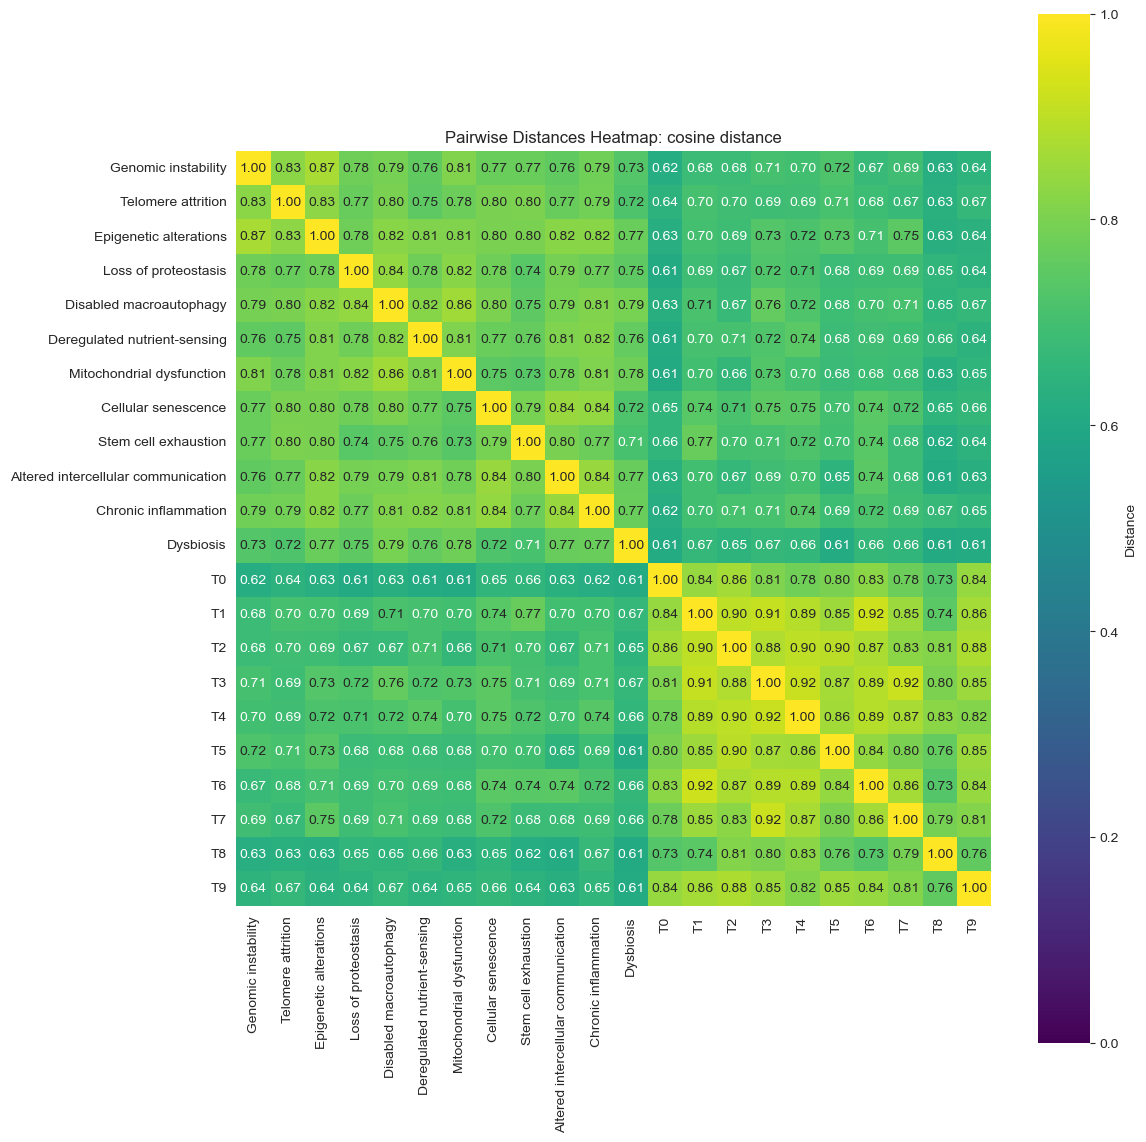

In [151]:
topic_2_embeddings = {**hallmarks_review_topic_2_embeddings, **pubmed_topic_2_embeddings}
# topic_2_embeddings = {**pubmed_topic_2_embeddings}
keys = list(topic_2_embeddings.keys())

# dist_fun_cosine = False
dist_fun_cosine = True
paired_dists = np.zeros(shape=(len(keys), len(keys)))
for i in range(len(keys)):
    for j in range(i, len(keys)):
        emb_i = topic_2_embeddings[keys[i]]
        emb_j = topic_2_embeddings[keys[j]]
        if dist_fun_cosine:
            dist_fun = cosine_similarity
        else:
            dist_fun = euclidean_distance
        paired_dists[i][j] = dist_fun(emb_i.embeddings[0].values, emb_j.embeddings[0].values)
        paired_dists[j][i] = paired_dists[i][j]

paired_dists = pd.DataFrame(data=paired_dists, columns=keys, index=keys)


plt.figure(figsize=(12, 12))
sns.heatmap(paired_dists,
            cmap="viridis",        # or 'coolwarm', 'magma', etc.
            annot=True,            # shows actual values
            fmt=".2f",             # format decimal precision
            square=True,           # make cells square
            cbar_kws={"label": "Distance"},
            vmin=0, vmax=1         # fix scale to 0–1
           )
plt.title(f"Pairwise Distances Heatmap: {'cosine distance' if dist_fun_cosine else 'euclidean distance'}")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()